# NLP Sentiment Analysis 
## Data Preprocessing
First, we load the dataset. The data we are using is from the FiQA 2018 Task 1 competition, which we import from hugging face. It is already split into train, validation, and test sets (70/10/20).

In [1]:
# Load the dataset, and rename column into the format 'trainer' expects
from datasets import load_dataset

ds = load_dataset("TheFinAI/fiqa-sentiment-classification")
ds = ds.rename_column("score", "labels")

In [2]:
# Seperate the given train-val-test split
train_ds = ds["train"]
val_ds = ds["valid"]
test_ds = ds["test"]

In [3]:
# Remove duplicate rows
from datasets import concatenate_datasets
import pandas as pd
from datasets import Dataset

def dup_drop(data):
    """Remove duplicates and shuffle the data"""
    df = data.to_pandas() # Using pandas for this task is more intuitive and neat
    df.drop_duplicates("sentence", inplace = True)
    df = df.sample(frac=1, random_state=42)
    return Dataset.from_pandas(df, preserve_index=False)
    
train_ds = dup_drop(train_ds)
val_ds = dup_drop(val_ds)
test_ds = dup_drop(test_ds)

Label Mean: 0.1222


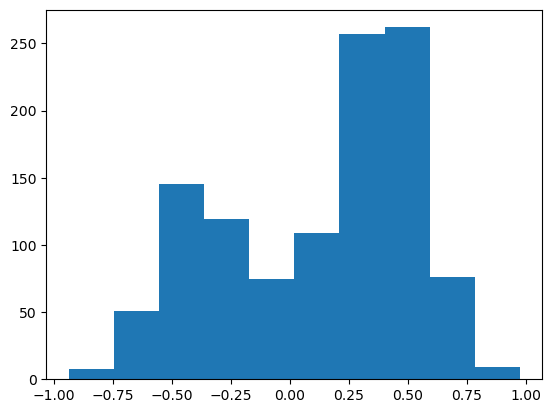

In [104]:
from datasets import concatenate_datasets
import matplotlib.pyplot as plt
import numpy as np

# We check the distribution of the sentiment scores by plotting a histogram, after removing duplicates. We see that the majority of points lie in the
# moderately positive range. These are more likely to be samppled later when we create the sentence pair dataset to train the embedding model.

original_ds = concatenate_datasets([train_ds, val_ds, test_ds])

plt.hist(original_ds["labels"])
print(f"Label Mean: {round(np.mean(original_ds["labels"]), 4)}")

## Baseline Models

### Predicting the Mean

In [4]:
import numpy as np
from datasets import concatenate_datasets
from sklearn.metrics import mean_squared_error

# Calculate the mean from the training data and validation data (no data leakage), then predict the scores in the test set using this mean
# We then find the MSE and R^2 from this prediction
scores_train = concatenate_datasets([train_ds, val_ds])["labels"]
scores_test = test_ds["labels"]
mean_train_scores = np.mean(scores_train)
mean_arr_train = np.array([mean_train_scores] * len(test_ds)) # Format mean_squared_error expects
mean_test_scores = np.mean(scores_test)
mean_arr_test = np.array([mean_test_scores] * len(test_ds)) # Format mean_squared_error expects
RSS_div_n = mean_squared_error(mean_arr_train, test_ds["labels"])
TSS_div_n = mean_squared_error(mean_arr_test, test_ds["labels"]) # We will use this TSS throughout the notebook
print(f"The MSE from predicting the train + val mean is: {RSS_div_n:.4f}")
print(f"The R^2 from predicting the train + val mean is: {(1-RSS_div_n/TSS_div_n):.4f}")


The MSE from predicting the train + val mean is: 0.1725
The R^2 from predicting the train + val mean is: -0.0216


**NOTE:** We use 'TSS_div_n' throughout the notebook for $\text{R}^{2}$ calculations. We also use the function below for calculating CI throughout

In [35]:
from scipy import stats

def confidence_intervals(mean, std, M, a):
    """CI calculation using standard error and t-distribution. Expected std ddof=1"""
    t_distribution = stats.t(df=M-1).ppf(0.5+a/2)
    upper_bound = mean + std/np.sqrt(M)*t_distribution # Upper bound C.I
    lower_bound = mean - std/np.sqrt(M)*t_distribution # Lower bound C.I
    return upper_bound, lower_bound

### XGBoost
XGBoost is a popular machine learning library. It is commonly among the winning models in Kaggle competitions. It uses gradient boosted decision trees to make its predictions. We standardise the datasets using nltk.

In [5]:
train_df = train_ds.to_pandas()
val_df = val_ds.to_pandas()
test_df = test_ds.to_pandas()

In [6]:
df = pd.concat([train_df, val_df, test_df], ignore_index=True )
df = df.loc[:, ["sentence", "labels"]]

In [7]:
# Import and download the necessary libraries

import nltk
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
nltk.download('wordnet')
nltk.download('omw-1.4')

import matplotlib
matplotlib.use('Agg')
from nltk.stem.porter import PorterStemmer
from nltk import WordNetLemmatizer
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwordSet = set(stopwords.words("english"))
import string

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\a2242\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\a2242\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a2242\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
lemma = WordNetLemmatizer()
preproc_text = []
for i in range(len(df)):
    text = df.sentence[i]
    text = tknzr.tokenize(text) # Split the sentence into their individual word tokens
    text = [word.lower() for word in text] # Remove capital letters
    text = [word.translate(str.maketrans('', '', string.punctuation)) for word in text] # Remove all punctuation
    text = [word for word in text if not word in stopwordSet] # Remove stop words ('a,' 'the,' 'be' etc.)
    text = [lemma.lemmatize(word) for word in text] # Lemmatise the word (reduce into its most basic form eg. apologies -> apology)
    text = " ".join(text)
    preproc_text.append(text)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xgb

# Create a bag-of-trigrams dataset, which also counts the number of occurences of a word in the processed sentence
vectorizer = CountVectorizer(ngram_range=(1, 3)) 
X = vectorizer.fit_transform(preproc_text).toarray() # strings to 1 and 0
y = df["labels"]

In [40]:
import numpy as np
import random
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

# Define hyperparameter ranges
param_grid = {
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.001, 0.01, 0.1, 0.2],
    "subsample": [i/10 for i in range(7, 11)],
    "colsample_bytree": [i/10 for i in range(7, 11)],
    "n_estimators": [10, 20, 30, 40, 50],
}
# We do not define early stopping. Therefore, we set the number of boosted trees as a hyperparameter itself
train_index = [i for i in range(770)]
val_index = [i for i in range(770, 881)]
cv = [(train_index, val_index)] # One cv iteration on train and val -- essentially hold-out validation
xg = xgb.XGBRegressor()
best_xgb = RandomizedSearchCV(xg, param_distributions=param_grid, verbose=0, n_jobs=-1, cv=cv, random_state=42, scoring="neg_mean_squared_error")
best_xgb.fit(X[:881], y[:881])

RandomizedSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                         16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                        [770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780,
                         781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791,
                         792, 793, 794, 795, 796, 797, 798, 799, ...])],
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9,
                                                             1.0],
                                        'learning_rate': [0.001, 0.01, 0.1,
                                                          0.2],
                                        'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [10, 20, 30, 40, 50],
                                        'subsample': [0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error')

In [50]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

best_params = best_xgb.best_params_

# Generate 20 random seeds for the 20 runs
rng = np.random.default_rng(seed=42)
seeds = np.random.randint(0, 10000, size=20).tolist() 

test_performance = [] # Where we will the store the 20 runs MSE
test_r2 = [] # Where we will store the 20 runs R^2
for seed in seeds:
    # Retrain best model
    final_model = xgb.XGBRegressor(**best_params, objective="reg:squarederror", random_state=seed)
    final_model.fit(X[:881], y[:881])
    
    # Evaluate
    y_pred = final_model.predict(X[881:])
    test_performance.append(mean_squared_error(y[881:], y_pred))
    test_r2.append(r2_score(y[881:], y_pred))

In [51]:
import numpy as np

mean, std = np.mean(test_performance), np.std(test_performance, ddof=1)
upper_bound, lower_bound = confidence_intervals(mean, std, 20, 0.95)
print(f"Average MSE for XGBoost is: {mean:.4f} ± {std:.4f}")
print(f"The confidence interval is: ({lower_bound:.4f}, {upper_bound:.4f})")

mean, std = np.mean(test_r2), np.std(test_r2, ddof=1)
upper_bound, lower_bound = confidence_intervals(mean, std, 20, 0.95)
print(f"Mean R^2 for XGBoost is: {mean:.4f} ± {std:.4f}")
print(f"The confidence interval is: ({lower_bound:.4f}, {upper_bound:.4f})")

Average MSE for XGBoost is: 0.1178 ± 0.0012
The confidence interval is: (0.1172, 0.1183)
Mean R^2 for XGBoost is: 0.3025 ± 0.0072
The confidence interval is: (0.2992, 0.3059)


 ## RoBERTa
Now, we load the RoBERTa model. We define functions that will be used later for BERT as well.

In [6]:
# Load RoBERTa from the hugging face 'transformers' library
from transformers import AutoTokenizer, AutoModelForSequenceClassification

def load_tokenizer(model_name):
    """Loads and returns tokeniser"""
    return AutoTokenizer.from_pretrained(model_name)

def model_init():
    """Initialises the model every time 'trainer.train()' is called"""
    return AutoModelForSequenceClassification.from_pretrained(
        "FacebookAI/roberta-base", num_labels=1, problem_type="regression"
    )

# Initialize tokeniser
tokenizer = load_tokenizer("FacebookAI/roberta-base")

In [9]:
import numpy as np
import evaluate
from sklearn.metrics import mean_squared_error
import numpy as np

def compute_metrics(eval_pred):
    """Calculates RMSE on the validation set"""
    predictions, labels = eval_pred
    rmse = np.sqrt(mean_squared_error(labels, predictions)) 
    return {"rmse": rmse}

In [10]:
from transformers import DataCollatorWithPadding
# Pad to the longest sequence in the batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
def preprocess_function(examples):
 """Tokenize input data"""
 return tokenizer(examples["sentence"], truncation=True)
# Tokenise train/test data
tokenized_train = train_ds.map(preprocess_function, batched=True)
tokenized_val = val_ds.map(preprocess_function, batched=True)
tokenized_test = test_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/770 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/230 [00:00<?, ? examples/s]

In [11]:
from transformers import TrainingArguments, Trainer

def define_model(train_data, test_data, epochs=10, seed=42):
    """Define the model that we will use to find the optimal number of training epochs, and for testing"""
    # Define the hyperparameters and where to save the mode, then initialise the trainer with the given arguments
    training_args = TrainingArguments(
     output_dir="model",
     seed=seed,
     save_strategy="no",
     logging_strategy="epoch",
     evaluation_strategy="epoch",
     learning_rate=2e-5,
     per_device_train_batch_size=16,
     per_device_eval_batch_size=16,
     num_train_epochs=epochs, # Run for a lot of epochs to see when we begin overfitting
     weight_decay=0.01,
     report_to="none",
    )
    
    # Initialise Trainer
    trainer = Trainer(
     model_init=model_init,
     args=training_args,
     train_dataset=train_data,
     eval_dataset=test_data,
     tokenizer=tokenizer,
     data_collator=data_collator,
     compute_metrics=compute_metrics,
    )

    return trainer

**NOTE:** As we do not have much data to work with, ideally, we would approximate the generalisation loss through cross validation, which have standard K-folds of 5-10. However, due to time constraints, we were not able to validate our embedding model through cross validation. Therefore, in the interest of consistency, we evaluate and test the RoBERTa model using the same train-val-test split used for the embedding model.

In [8]:
# Train the model with the above optimal num of epochs
# Note, we skip hyperparameter tuning to save time. The results from a tuned RoBERTa model for this task have alreay been reported by
# Kelvin Du et al. https://doi.org/10.1145/3580480
trainer = define_model(tokenized_train, tokenized_val)
trainer.train()

C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_62752\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.den

Epoch,Training Loss,Validation Loss,Rmse
1,0.148200,0.059727,0.244391
2,0.084100,0.059307,0.243531
3,0.055200,0.052635,0.229424
4,0.040000,0.044035,0.209846
5,0.033100,0.045895,0.214232
6,0.027300,0.042015,0.204975
7,0.020600,0.044803,0.211668
8,0.017300,0.042652,0.206524
9,0.018400,0.047331,0.217558
10,0.014000,0.046166,0.214864


TrainOutput(global_step=490, training_loss=0.04579968318647268, metrics={'train_runtime': 61.3967, 'train_samples_per_second': 125.414, 'train_steps_per_second': 7.981, 'total_flos': 168098705076924.0, 'train_loss': 0.04579968318647268, 'epoch': 10.0})

In [12]:
def extract_loss(logs):
    """Get the loss from the log history"""
    training_loss = [logs[i]["loss"] for i in range(0, len(logs[:-1]), 2)]
    eval_loss = [logs[i]["eval_loss"] for i in range(1, len(logs[:-1]), 2)]
    return training_loss, eval_loss

training_loss, eval_loss = extract_loss(trainer.state.log_history)

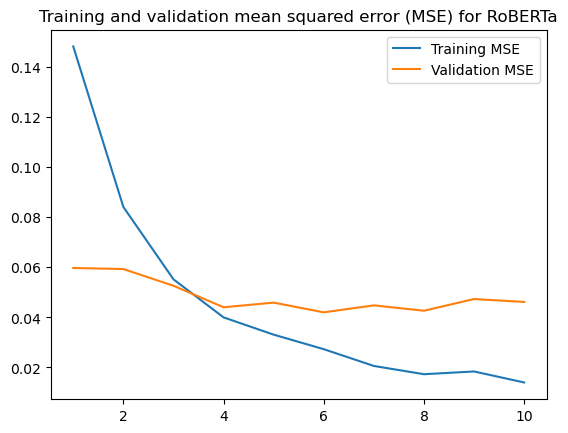

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

def create_loss_plots(training_loss, eval_loss, train_epochs, model):
    """Creates plots of the train and validation loss"""
    epochs = range(1, train_epochs+1)
    plt.plot(epochs, training_loss, label="Training MSE")
    plt.plot(epochs, eval_loss, label="Validation MSE")
    plt.title(f"Training and validation mean squared error (MSE) for {model}")
    plt.legend()
    plt.savefig(f"train_val_{model}.png")
    plt.show()

create_loss_plots(training_loss, eval_loss, 10, "RoBERTa")



Now, we test the model on the test set, with 20 seeded runs. We find the average, and standard deviation, of the MSE and $\text{R}^{2}$ and report it.

**NOTE:** We will use the above function in all the CI calculations from now on

In [10]:
import numpy as np

# Generate 20 random seeds for the 20 runs
rng = np.random.default_rng(seed=42)
seeds = np.random.randint(0, 10000, size=20).tolist() 

test_performance = [] # Where we will the store the 20 runs MSE
test_r2 = [] # Where we will store the 20 runs R^2
for seed in seeds:
    trainer = define_model(tokenized_train, tokenized_test, epochs=6, seed=seed)
    trainer.train()
    RSS_div_n = trainer.state.log_history[-2]["eval_loss"]
    test_performance.append(RSS_div_n)
    test_r2.append(1-RSS_div_n/TSS_div_n)

C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_68524\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.den

Epoch,Training Loss,Validation Loss,Rmse
1,0.158200,0.130126,0.360730
2,0.100300,0.098291,0.313514
3,0.069800,0.066345,0.257576
4,0.041500,0.049661,0.222847
5,0.031400,0.051206,0.226287
6,0.024600,0.052366,0.228837


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_68524\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.den

Epoch,Training Loss,Validation Loss,Rmse
1,0.170500,0.158750,0.398434
2,0.112900,0.060272,0.245503
3,0.061100,0.064725,0.254411
4,0.049500,0.046702,0.216106
5,0.033900,0.052816,0.229818
6,0.027800,0.053711,0.231755


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_68524\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.den

Epoch,Training Loss,Validation Loss,Rmse
1,0.183700,0.118820,0.344703
2,0.096000,0.071029,0.266512
3,0.055700,0.075869,0.275444
4,0.039800,0.050928,0.225673
5,0.028600,0.054654,0.233783
6,0.024700,0.051040,0.225920


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_68524\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.den

Epoch,Training Loss,Validation Loss,Rmse
1,0.167400,0.132802,0.364420
2,0.098900,0.069486,0.263602
3,0.054800,0.080426,0.283594
4,0.039300,0.055723,0.236057
5,0.029100,0.055203,0.234953
6,0.023700,0.057425,0.239634


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_68524\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.den

Epoch,Training Loss,Validation Loss,Rmse
1,0.165900,0.148649,0.385550
2,0.097300,0.084073,0.289953
3,0.052300,0.061591,0.248175
4,0.035100,0.058151,0.241145
5,0.030000,0.065182,0.255308
6,0.021700,0.055342,0.235248


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_68524\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.den

Epoch,Training Loss,Validation Loss,Rmse
1,0.167200,0.125747,0.354609
2,0.090800,0.083039,0.288165
3,0.055000,0.067336,0.259491
4,0.037900,0.061196,0.247378
5,0.028300,0.069664,0.263939
6,0.026400,0.061058,0.247099


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_68524\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.den

Epoch,Training Loss,Validation Loss,Rmse
1,0.159900,0.083904,0.289661
2,0.074400,0.063677,0.252344
3,0.045000,0.065131,0.255208
4,0.039600,0.053005,0.230228
5,0.028800,0.050516,0.224758
6,0.025300,0.051108,0.226072


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_68524\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.den

Epoch,Training Loss,Validation Loss,Rmse
1,0.155800,0.109828,0.331402
2,0.102300,0.060676,0.246325
3,0.059700,0.073526,0.271157
4,0.042400,0.057139,0.239038
5,0.032700,0.057358,0.239496
6,0.030000,0.059040,0.242982


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_68524\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.den

Epoch,Training Loss,Validation Loss,Rmse
1,0.170900,0.173093,0.416045
2,0.098800,0.068300,0.261343
3,0.064000,0.063346,0.251685
4,0.043200,0.076533,0.276647
5,0.034400,0.060822,0.246621
6,0.028200,0.061268,0.247524


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_68524\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.den

Epoch,Training Loss,Validation Loss,Rmse
1,0.158600,0.089020,0.298363
2,0.081000,0.063069,0.251136
3,0.053300,0.059762,0.244462
4,0.039100,0.050931,0.225680
5,0.030400,0.053036,0.230295
6,0.027400,0.051923,0.227866


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_68524\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.den

Epoch,Training Loss,Validation Loss,Rmse
1,0.158800,0.148047,0.384769
2,0.096700,0.068120,0.260998
3,0.049800,0.073531,0.271166
4,0.036400,0.058990,0.242879
5,0.028600,0.062126,0.249250
6,0.023000,0.056823,0.238376


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_68524\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.den

Epoch,Training Loss,Validation Loss,Rmse
1,0.163700,0.115777,0.340261
2,0.082900,0.075645,0.275037
3,0.054900,0.053382,0.231046
4,0.040100,0.055400,0.235372
5,0.030700,0.059139,0.243186
6,0.025700,0.054863,0.234228


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_68524\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.den

Epoch,Training Loss,Validation Loss,Rmse
1,0.173500,0.147936,0.384624
2,0.109000,0.069903,0.264391
3,0.060100,0.054380,0.233195
4,0.047300,0.058153,0.241150
5,0.036800,0.049634,0.222786
6,0.033500,0.050560,0.224855


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_68524\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.den

Epoch,Training Loss,Validation Loss,Rmse
1,0.145200,0.078380,0.279964
2,0.072300,0.063549,0.252090
3,0.048900,0.062419,0.249838
4,0.035900,0.063303,0.251601
5,0.028300,0.064059,0.253098
6,0.021300,0.059946,0.244839


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_68524\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.den

Epoch,Training Loss,Validation Loss,Rmse
1,0.157800,0.080446,0.283630
2,0.081700,0.074051,0.272123
3,0.049200,0.063992,0.252966
4,0.038700,0.054547,0.233554
5,0.029600,0.054915,0.234338
6,0.024300,0.055141,0.234820


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_68524\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.den

Epoch,Training Loss,Validation Loss,Rmse
1,0.166500,0.162652,0.403301
2,0.116000,0.070539,0.265592
3,0.056900,0.062901,0.250801
4,0.044300,0.051642,0.227249
5,0.028300,0.049467,0.222413
6,0.025400,0.051068,0.225981


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_68524\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.den

Epoch,Training Loss,Validation Loss,Rmse
1,0.167900,0.133375,0.365206
2,0.096100,0.058124,0.241089
3,0.051100,0.063557,0.252104
4,0.035300,0.058371,0.241601
5,0.030100,0.053949,0.232270
6,0.023200,0.057017,0.238782


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_68524\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.den

Epoch,Training Loss,Validation Loss,Rmse
1,0.169900,0.092616,0.304329
2,0.086400,0.070416,0.265360
3,0.050300,0.072765,0.269751
4,0.037600,0.049955,0.223507
5,0.030400,0.062706,0.250412
6,0.024200,0.056973,0.238690


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_68524\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.den

Epoch,Training Loss,Validation Loss,Rmse
1,0.150300,0.077873,0.279057
2,0.083600,0.061460,0.247911
3,0.056200,0.066359,0.257602
4,0.033600,0.050383,0.224462
5,0.028200,0.058145,0.241133
6,0.022200,0.061159,0.247304


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_68524\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.den

Epoch,Training Loss,Validation Loss,Rmse
1,0.166900,0.156527,0.395635
2,0.105900,0.059984,0.244916
3,0.054800,0.063755,0.252497
4,0.040500,0.055360,0.235288
5,0.034200,0.059665,0.244264
6,0.027100,0.059011,0.242921


In [12]:
import numpy as np

mean, std = np.mean(test_performance), np.std(test_performance, ddof=1)
upper_bound, lower_bound = confidence_intervals(mean, std, 20, 0.95)
print(f"Average MSE for the base RoBERTa model: {mean:.4f} ± {std:.4f}")
print(f"The confidence interval is: ({lower_bound:.4f}, {upper_bound:.4f})")

mean, std = np.mean(test_r2), np.std(test_r2, ddof=1)
upper_bound, lower_bound = confidence_intervals(mean, std, 20, 0.95)
print(f"Mean R^2 for the base RoBERTa model: {mean:.4f} ± {std:.4f}")
print(f"The confidence interval is: ({lower_bound:.4f}, {upper_bound:.4f})")

Average MSE for the base RoBERTa model: 0.0558 ± 0.0037
The confidence interval is: (0.0541, 0.0576)
Mean R^2 for the base RoBERTa model: 0.6693 ± 0.0218
The confidence interval is: (0.6590, 0.6795)


Clearly a greater MSE than Kelvin Du et al. [https://doi.org/10.1145/3580480], but this is expected since we did not perform any hyperparameter tuning.

In [20]:
trainer.save_model("fine-tune-roberta")

Now, we expose the anisotropy in BERT models. We calculate the mean cosine similarity among all the sentence embeddings in our data, calculated form average pooling the individual word embeddings. If the sentence embeddings are spread unifromly, the mean cosine similarity should be close to 0. Nonetheless, we see an exceptionally high cosine similarity of 0.8613, meaning that a large majority of vectors point in a very similar direction.

In [40]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load fine-tuned RoBERTa model
model_name = "fine-tune-roberta"  
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

sentences = concatenate_datasets([train_ds, val_ds, test_ds])["sentence"]

# Tokenise and get embeddings
def get_sentence_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
     # Take the mean across all tokens (excluding padding)
    attention_mask = inputs["attention_mask"]  # Identify valid tokens (not padded)
    token_embeddings = outputs.last_hidden_state  # Get the final embeddings

    # Compute mean only over valid tokens 
    sentence_embedding = (token_embeddings * attention_mask.unsqueeze(-1)).sum(dim=1) / attention_mask.sum(dim=1, keepdim=True)

    return sentence_embedding.squeeze().numpy()  # Convert to NumPy array

# Compute embeddings
embeddings = np.array([get_sentence_embedding(sent) for sent in sentences])

# Compute pairwise cosine similarities
cos_sim_matrix = cosine_similarity(embeddings)

# Compute mean cosine similarity
mean_cosine_similarity = np.mean(cos_sim_matrix)
print(f"Mean Cosine Similarity: {mean_cosine_similarity:.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at fine-tune-roberta and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Mean Cosine Similarity: 0.8613


**NOTE:** Ignore the warning, we do not use the pooling layers here.

## BERT
We do the same for the BERT model now, for comparison with RoBERTa.

In [7]:
def load_tokenizer(model_name):
    """Loads and returns tokeniser"""
    return AutoTokenizer.from_pretrained(model_name)

# Function so we can instantiate the model every time upon calling trainer.train()

def model_init():
    """Initialises the model every time 'trainer.train()' is called"""
    return AutoModelForSequenceClassification.from_pretrained(
        "bert-base-cased", num_labels=1, problem_type="regression" # Note: we use bert-base-cased since casings matter for sentiment 
    )

# Initialise tokeniser
tokenizer = load_tokenizer("bert-base-cased")

In [14]:
# Pad to the longest sequence in the batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# Load the data using functions defined previously
tokenized_train = train_ds.map(preprocess_function, batched=True)
tokenized_val = val_ds.map(preprocess_function, batched=True)
tokenized_test = test_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/770 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/230 [00:00<?, ? examples/s]

In [24]:
trainer = define_model(tokenized_train, tokenized_val, epochs=20) # Train for longer since bert-base-cased starts overfitting later
trainer.train()

C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_62752\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be ab

Epoch,Training Loss,Validation Loss,Rmse
1,0.173700,0.149826,0.387074
2,0.137200,0.103060,0.321030
3,0.080800,0.089027,0.298373
4,0.051200,0.092129,0.303527
5,0.035100,0.082853,0.287842
6,0.025900,0.087352,0.295553
7,0.020200,0.091470,0.302440
8,0.016600,0.078521,0.280216
9,0.012200,0.078260,0.279750
10,0.009800,0.073955,0.271947


TrainOutput(global_step=980, training_loss=0.031339569967620225, metrics={'train_runtime': 128.8268, 'train_samples_per_second': 119.54, 'train_steps_per_second': 7.607, 'total_flos': 379910452850472.0, 'train_loss': 0.031339569967620225, 'epoch': 20.0})

In [25]:
training_loss, eval_loss = extract_loss(trainer.state.log_history)

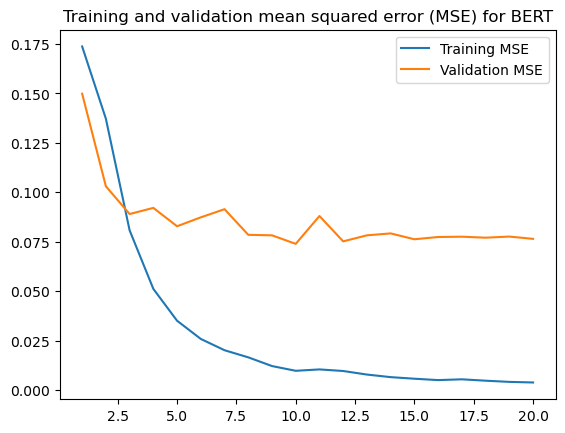

In [26]:
create_loss_plots(training_loss, eval_loss, 20, "BERT")

In [16]:
# Generate 20 random seeds for the 20 runs
rng = np.random.default_rng(seed=42)
seeds = np.random.randint(0, 10000, size=20).tolist() 

# Append the test set performance so we can comppute the necessary statistics afterwards
test_performance = []
test_r2 = []
for seed in seeds:
    trainer = define_model(tokenized_train, tokenized_test, epochs=10, seed=seed)
    trainer.train()
    RSS_div_n = trainer.state.log_history[-2]["eval_loss"]
    test_performance.append(RSS_div_n)
    test_r2.append(1-RSS_div_n/TSS_div_n) # Use TSS defined from earlier

C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_45456\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be ab

Epoch,Training Loss,Validation Loss,Rmse
1,0.199600,0.147440,0.383979
2,0.124700,0.109198,0.330452
3,0.075400,0.099361,0.315216
4,0.045200,0.090181,0.300302
5,0.031800,0.113145,0.336370
6,0.022200,0.111905,0.334521
7,0.020200,0.082977,0.288056
8,0.013900,0.086904,0.294795
9,0.010500,0.082905,0.287933
10,0.010700,0.082405,0.287063


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_45456\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be ab

Epoch,Training Loss,Validation Loss,Rmse
1,0.184500,0.125851,0.354755
2,0.105800,0.116569,0.341421
3,0.062100,0.090503,0.300836
4,0.037700,0.094846,0.307971
5,0.028100,0.100528,0.317061
6,0.022100,0.116402,0.341178
7,0.017300,0.094637,0.307632
8,0.015200,0.087491,0.295788
9,0.010700,0.091767,0.302931
10,0.010100,0.085676,0.292704


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_45456\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be ab

Epoch,Training Loss,Validation Loss,Rmse
1,0.174800,0.117398,0.342634
2,0.090600,0.098639,0.314068
3,0.065100,0.097191,0.311755
4,0.046800,0.098554,0.313932
5,0.033200,0.092385,0.303948
6,0.023600,0.106207,0.325894
7,0.018800,0.095186,0.308523
8,0.014100,0.088504,0.297496
9,0.012600,0.088511,0.297507
10,0.010400,0.090397,0.300660


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_45456\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be ab

Epoch,Training Loss,Validation Loss,Rmse
1,0.184900,0.154722,0.393348
2,0.131600,0.132632,0.364187
3,0.078700,0.100076,0.316348
4,0.046000,0.106263,0.325980
5,0.029800,0.091665,0.302763
6,0.021100,0.089587,0.299311
7,0.015600,0.085221,0.291926
8,0.012100,0.088131,0.296869
9,0.012300,0.089807,0.299677
10,0.009000,0.087809,0.296326


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_45456\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be ab

Epoch,Training Loss,Validation Loss,Rmse
1,0.184900,0.157133,0.396400
2,0.142400,0.106001,0.325578
3,0.069800,0.094754,0.307822
4,0.043500,0.087297,0.295461
5,0.026300,0.089938,0.299897
6,0.016600,0.098263,0.313470
7,0.013500,0.086928,0.294835
8,0.012300,0.091604,0.302662
9,0.010300,0.085408,0.292246
10,0.008400,0.083545,0.289042


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_45456\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be ab

Epoch,Training Loss,Validation Loss,Rmse
1,0.182900,0.131674,0.362869
2,0.098800,0.108173,0.328897
3,0.054900,0.093450,0.305695
4,0.031900,0.096347,0.310398
5,0.021600,0.084809,0.291220
6,0.017000,0.090742,0.301235
7,0.013700,0.094336,0.307142
8,0.009900,0.084446,0.290597
9,0.008200,0.084270,0.290293
10,0.008100,0.082716,0.287603


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_45456\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be ab

Epoch,Training Loss,Validation Loss,Rmse
1,0.185400,0.145522,0.381473
2,0.099800,0.105035,0.324092
3,0.053600,0.116036,0.340640
4,0.034600,0.088276,0.297113
5,0.021200,0.092289,0.303791
6,0.016100,0.077949,0.279194
7,0.011100,0.078863,0.280826
8,0.009300,0.075707,0.275148
9,0.008500,0.080065,0.282958
10,0.007700,0.077486,0.278364


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_45456\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be ab

Epoch,Training Loss,Validation Loss,Rmse
1,0.212900,0.161960,0.402443
2,0.143200,0.122832,0.350474
3,0.087400,0.104814,0.323749
4,0.044400,0.119785,0.346100
5,0.031300,0.090807,0.301342
6,0.022900,0.092335,0.303867
7,0.018300,0.093307,0.305461
8,0.013300,0.093616,0.305967
9,0.010300,0.090366,0.300610
10,0.010500,0.090672,0.301118


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_45456\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be ab

Epoch,Training Loss,Validation Loss,Rmse
1,0.187100,0.167500,0.409267
2,0.139600,0.091633,0.302710
3,0.065400,0.096801,0.311128
4,0.043400,0.100879,0.317614
5,0.025900,0.085718,0.292776
6,0.016100,0.086159,0.293529
7,0.013400,0.087410,0.295652
8,0.011200,0.081590,0.285639
9,0.009800,0.078252,0.279736
10,0.008500,0.078921,0.280930


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_45456\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be ab

Epoch,Training Loss,Validation Loss,Rmse
1,0.194700,0.152323,0.390286
2,0.119500,0.104239,0.322861
3,0.071200,0.098075,0.313170
4,0.047000,0.093919,0.306461
5,0.037500,0.090286,0.300476
6,0.025000,0.091055,0.301753
7,0.019300,0.095874,0.309636
8,0.017800,0.094706,0.307744
9,0.012200,0.090349,0.300582
10,0.010700,0.088971,0.298280


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_45456\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be ab

Epoch,Training Loss,Validation Loss,Rmse
1,0.175000,0.126457,0.355608
2,0.092100,0.110054,0.331743
3,0.065200,0.106701,0.326651
4,0.036900,0.101384,0.318409
5,0.025500,0.096925,0.311327
6,0.018200,0.103977,0.322454
7,0.014500,0.088264,0.297093
8,0.012100,0.084903,0.291382
9,0.009100,0.083321,0.288653
10,0.007400,0.086191,0.293584


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_45456\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be ab

Epoch,Training Loss,Validation Loss,Rmse
1,0.175700,0.166437,0.407967
2,0.130400,0.117272,0.342449
3,0.067100,0.099640,0.315658
4,0.042400,0.088923,0.298200
5,0.027100,0.091046,0.301739
6,0.023700,0.085957,0.293184
7,0.016700,0.088545,0.297565
8,0.016500,0.078650,0.280445
9,0.012700,0.080879,0.284392
10,0.010600,0.082478,0.287190


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_45456\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be ab

Epoch,Training Loss,Validation Loss,Rmse
1,0.180600,0.144945,0.380717
2,0.105200,0.102509,0.320170
3,0.060300,0.100266,0.316649
4,0.034200,0.145392,0.381303
5,0.029300,0.081638,0.285724
6,0.017600,0.081515,0.285509
7,0.013200,0.083677,0.289269
8,0.012200,0.084275,0.290301
9,0.009000,0.081761,0.285939
10,0.008800,0.081634,0.285717


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_45456\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be ab

Epoch,Training Loss,Validation Loss,Rmse
1,0.180500,0.146219,0.382386
2,0.120400,0.113623,0.337080
3,0.071300,0.109245,0.330522
4,0.053600,0.115510,0.339867
5,0.040200,0.086967,0.294902
6,0.025800,0.090050,0.300084
7,0.019900,0.091131,0.301879
8,0.015300,0.088435,0.297381
9,0.012300,0.087764,0.296250
10,0.011800,0.088268,0.297099


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_45456\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be ab

Epoch,Training Loss,Validation Loss,Rmse
1,0.180500,0.136755,0.369804
2,0.114700,0.101143,0.318029
3,0.054800,0.091132,0.301881
4,0.037100,0.085611,0.292594
5,0.025000,0.073548,0.271198
6,0.019400,0.088365,0.297262
7,0.015100,0.084558,0.290789
8,0.010700,0.077815,0.278953
9,0.008400,0.077388,0.278188
10,0.008200,0.077450,0.278298


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_45456\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be ab

Epoch,Training Loss,Validation Loss,Rmse
1,0.194600,0.151685,0.389468
2,0.126900,0.132204,0.363599
3,0.080600,0.117079,0.342167
4,0.062400,0.118518,0.344264
5,0.036800,0.095394,0.308859
6,0.026800,0.097531,0.312299
7,0.020000,0.101174,0.318079
8,0.016200,0.097873,0.312847
9,0.015900,0.099732,0.315803
10,0.012000,0.099836,0.315968


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_45456\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be ab

Epoch,Training Loss,Validation Loss,Rmse
1,0.185100,0.161545,0.401927
2,0.130800,0.116933,0.341954
3,0.067100,0.099478,0.315401
4,0.045000,0.091575,0.302613
5,0.030300,0.103246,0.321318
6,0.021700,0.091964,0.303256
7,0.018300,0.088149,0.296899
8,0.013500,0.091415,0.302349
9,0.011800,0.089918,0.299863
10,0.009100,0.090844,0.301403


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_45456\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be ab

Epoch,Training Loss,Validation Loss,Rmse
1,0.188500,0.142644,0.377683
2,0.106800,0.098209,0.313384
3,0.056900,0.117700,0.343075
4,0.039700,0.096626,0.310846
5,0.028800,0.087834,0.296369
6,0.021400,0.089925,0.299875
7,0.015900,0.085903,0.293092
8,0.012300,0.089290,0.298815
9,0.011200,0.084225,0.290215
10,0.008800,0.084642,0.290934


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_45456\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be ab

Epoch,Training Loss,Validation Loss,Rmse
1,0.176800,0.147223,0.383696
2,0.110000,0.107978,0.328599
3,0.053600,0.133377,0.365208
4,0.041800,0.092153,0.303567
5,0.023900,0.091920,0.303183
6,0.018400,0.098552,0.313929
7,0.013900,0.097885,0.312865
8,0.011600,0.086699,0.294448
9,0.010200,0.084291,0.290330
10,0.007300,0.085781,0.292884


C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\a2242\AppData\Local\Temp\ipykernel_45456\29983871.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be ab

Epoch,Training Loss,Validation Loss,Rmse
1,0.183600,0.151629,0.389396
2,0.117700,0.107606,0.328034
3,0.063900,0.087854,0.296403
4,0.039600,0.093859,0.306363
5,0.027400,0.080534,0.283785
6,0.016500,0.078555,0.280277
7,0.014800,0.080378,0.283509
8,0.011500,0.078764,0.280648
9,0.010300,0.078842,0.280788
10,0.008600,0.077492,0.278374


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [21:25<00:00, 64.26s/it]


In [17]:
import numpy as np

mean, std = np.mean(test_performance), np.std(test_performance, ddof=1)
upper_bound, lower_bound = confidence_intervals(mean, std, 20, 0.95)
print(f"Average MSE for base BERT model (cased): {mean:.4f} ± {std:.4f}")
print(f"The confidence interval is: ({lower_bound:.4f}, {upper_bound:.4f})")

mean, std = np.mean(test_r2), np.std(test_r2, ddof=1)
upper_bound, lower_bound = confidence_intervals(mean, std, 20, 0.95)
print(f"Mean R^2 for bse BERT model (cased): {mean:.4f} ± {std:.4f}")
print(f"The confidence interval is: ({lower_bound:.4f}, {upper_bound:.4f})")

Average MSE for base BERT model (cased): 0.0852 ± 0.0056
The confidence interval is: (0.0826, 0.0878)
Mean R^2 for bse BERT model (cased): 0.4956 ± 0.0330
The confidence interval is: (0.4801, 0.5111)


## Embedding Model

Next, we load a pretrained embedding model, 'all-mpnet-base-v2.' It was finetuned on Microsoft's pretrained MPNet model, creating semantic embeddings through a contrastive loss function -- cross-entropy loss over cosine similarity for sentence pairs. It was finetuned on 1B pairs. Since this is the main part our research is concerned about, we will cover it more rigorously. 

In [5]:
from sentence_transformers import SentenceTransformer

# Define the embedding model
embedding_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

In [6]:
import random
from datasets import Dataset

# We need to create a dataset that we can use on the model to finetune it using cosine similarity loss, which is just MSE on cosine similarity
# We take inspiration from SetFit, and generate sentence pairs, with a user chosen number of pairs for each sentence
def contrastive_data(data, num_samples):
    """Generate sentence pairs from dataset provided. score_diff is chosen to be the absolute value of the distance of the scores"""
    data = list(data) # Change the dataset into a list
    random.seed(42) # Set seed for reproducibility
    train_examples = {"sentence1": [], "sentence2": [], "label": []}
    for row in data:
        chosen = [row]
        for _ in range(num_samples):
            choice_2 = random.choice([item for item in data if item != chosen]) # Such that at each pass we create unique pairs
            chosen.append(choice_2)
            score_diff = abs(row["labels"] - choice_2["labels"])
            
            similarity = 1-score_diff  # Linear difference (closer scores = higher similarity). Proxy for cosine similarity
            
            train_examples["sentence1"].append(row["sentence"])
            train_examples["sentence2"].append(choice_2["sentence"])
            train_examples["label"].append(similarity)

    # Shuffle the data
    train_examples = Dataset.from_dict(train_examples)
    df = train_examples.to_pandas()
    df = df.sample(frac=1, random_state=42)
    
    return Dataset.from_pandas(df, preserve_index=False)

In [7]:
from datasets import Dataset
# Generate another train-val split, since we do not want to overfit the validation set in both the embedding training, and final dense layer training
train_data_embedding = Dataset.train_test_split(train_ds, test_size=0.2, seed=42) # seed for reproducibility/ set aside 20% for validation
train_ds_1 = train_data_embedding["train"]
val_ds_1 = train_data_embedding["test"]

# This will be the validation set we use for evaluating our hyperaprameters
embedding_val = contrastive_data(val_ds_1, 30)

In [11]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

# Create an embedding similarity evaluator for validation set
evaluator = EmbeddingSimilarityEvaluator(
 sentences1=embedding_val["sentence1"],
 sentences2=embedding_val["sentence2"],
 scores=[score for score in embedding_val["label"]],
 main_similarity="cosine"
)


In [12]:
import optuna
import os 
import json
from transformers import EarlyStoppingCallback
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments

def hyperparam_search(data, data_name):
    """Searches for the best hyperparameters given the validation set defined above. Number of samples is chosen to be a hyperparameter"""
    
    search_space = {"learning_rate": [2e-5, 3e-5, 5e-5],
                   }

    hyperparam_dir = f"./fiqa/hyperparam/{data_name}"
    os.makedirs(hyperparam_dir, exist_ok=True) # Create the directory
    
    def objective(trial):
        """Suggests hyperparameters"""
        
        num_samples = trial.suggest_int("num_samples", 10, 30)
        learning_rate = trial.suggest_categorical("learning_rate", search_space["learning_rate"])
    

        embedding_train = contrastive_data(train_ds_1, num_samples)

        # Define model
        embedding_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
        # Loss function
        train_loss = losses.CosineSimilarityLoss(model=embedding_model)
        # Define the training arguments
        args = SentenceTransformerTrainingArguments(
         output_dir=hyperparam_dir,
         num_train_epochs=5,
         learning_rate=learning_rate,
         per_device_train_batch_size=32, # We noticed that this batch size performed best on our validation data, so to save time, have just set it
         per_device_eval_batch_size=32,
         save_strategy="epoch",
         evaluation_strategy="epoch",
         metric_for_best_model="pearson_cosine",
         load_best_model_at_end=True,
         warmup_steps=100, # *Same as batch size*
         fp16=True, # For faster training
        )
        
        # Train model
        trainer = SentenceTransformerTrainer(
         model=embedding_model,
         args=args,
         train_dataset=embedding_train,
         eval_dataset=embedding_val,
         loss=train_loss,
         evaluator=evaluator,
         callbacks=[EarlyStoppingCallback(early_stopping_patience=2)] # Low patience to speed up the hyperparameter search
        )
    
        trainer.train()
        eval_results = evaluator(embedding_model)
        return eval_results["pearson_cosine"]
    
    # Run the study
    study = optuna.create_study(direction="maximize") # We us the standard Bayesian optimisation from Optuna to guide our search
    study.optimize(objective, n_trials=9) 

    hyperparam_file = os.path.join(hyperparam_dir, "best_hyperparam.json")
    with open(hyperparam_file, "w") as f:
        json.dump(study.best_params, f, indent=4) # Save the best hyperparameters
    
    return {data_name: study.best_params}
    
hyperparam_search(train_ds_1, "embedding_train")

[I 2025-03-11 17:22:00,861] A new study created in memory with name: no-name-fc4a50a5-cd5f-4588-bc3b-97009e429121
C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Epoch,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
1,No log,0.059593,0.690980,0.629721
2,0.030800,0.060737,0.696923,0.639575
3,0.002700,0.060479,0.700782,0.640601
4,0.001700,0.060644,0.701676,0.642461
5,0.001700,0.059215,0.707945,0.648988


[I 2025-03-11 17:29:41,815] Trial 0 finished with value: 0.7079445931681527 and parameters: {'num_samples': 20, 'learning_rate': 3e-05}. Best is trial 0 with value: 0.7079445931681527.
C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Epoch,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
1,0.037100,0.064582,0.665717,0.605665
2,0.003600,0.063529,0.680792,0.623361
3,0.002200,0.063936,0.677894,0.623208
4,0.001700,0.063669,0.684357,0.630821
5,0.001400,0.063550,0.684293,0.630638


[I 2025-03-11 17:39:51,165] Trial 1 finished with value: 0.6843570680092532 and parameters: {'num_samples': 29, 'learning_rate': 2e-05}. Best is trial 0 with value: 0.7079445931681527.
C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Epoch,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
1,No log,0.070521,0.635094,0.577239
2,0.033900,0.062940,0.679541,0.619814
3,0.033900,0.067286,0.665410,0.609426
4,0.003500,0.065494,0.674772,0.620737


[I 2025-03-11 17:45:19,779] Trial 2 finished with value: 0.6795412522815196 and parameters: {'num_samples': 17, 'learning_rate': 2e-05}. Best is trial 0 with value: 0.7079445931681527.
C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Epoch,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
1,No log,0.056786,0.707203,0.650139
2,No log,0.062195,0.692920,0.635222
3,0.025400,0.061927,0.693375,0.632765


[I 2025-03-11 17:48:42,006] Trial 3 finished with value: 0.707202895235522 and parameters: {'num_samples': 12, 'learning_rate': 5e-05}. Best is trial 0 with value: 0.7079445931681527.
C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Epoch,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
1,0.036100,0.061159,0.686860,0.624104
2,0.003500,0.063785,0.677651,0.622286
3,0.002200,0.061292,0.695250,0.640311
4,0.001600,0.062116,0.691684,0.637279
5,0.001400,0.062014,0.692846,0.638659


[I 2025-03-11 17:58:18,990] Trial 4 finished with value: 0.6952499471836219 and parameters: {'num_samples': 27, 'learning_rate': 2e-05}. Best is trial 0 with value: 0.7079445931681527.
C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Epoch,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
1,No log,0.066111,0.652287,0.591026
2,0.035400,0.061774,0.680209,0.623192
3,0.035400,0.063877,0.679492,0.623467
4,0.003800,0.063609,0.682306,0.627662
5,0.003800,0.062802,0.683003,0.627509


[I 2025-03-11 18:04:36,779] Trial 5 finished with value: 0.6830029347170904 and parameters: {'num_samples': 15, 'learning_rate': 2e-05}. Best is trial 0 with value: 0.7079445931681527.
C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Epoch,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
1,0.036100,0.061159,0.686860,0.624104
2,0.003500,0.063785,0.677651,0.622286
3,0.002200,0.061292,0.695250,0.640311
4,0.001600,0.062116,0.691684,0.637279
5,0.001400,0.062014,0.692846,0.638659


[I 2025-03-11 18:14:09,974] Trial 6 finished with value: 0.6952499471836219 and parameters: {'num_samples': 27, 'learning_rate': 2e-05}. Best is trial 0 with value: 0.7079445931681527.
C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Epoch,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
1,No log,0.073049,0.633214,0.569180
2,No log,0.066785,0.656972,0.596476
3,0.029800,0.065094,0.664923,0.598202
4,0.029800,0.064259,0.670139,0.607902
5,0.029800,0.065353,0.667581,0.607258


[I 2025-03-11 18:19:04,679] Trial 7 finished with value: 0.670138703397472 and parameters: {'num_samples': 10, 'learning_rate': 3e-05}. Best is trial 0 with value: 0.7079445931681527.
C:\Users\a2242\anaconda3\envs\torch\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Epoch,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
1,No log,0.060298,0.693629,0.635116
2,0.031100,0.056959,0.712396,0.654423
3,0.002700,0.062148,0.693937,0.638164
4,0.001700,0.061515,0.696427,0.636979


[I 2025-03-11 18:25:53,179] Trial 8 finished with value: 0.7123960131712563 and parameters: {'num_samples': 23, 'learning_rate': 3e-05}. Best is trial 8 with value: 0.7123960131712563.


{'train_nli': {'num_samples': 23, 'learning_rate': 3e-05}}

We see that we should use a learning rate of 3e-05, 23 pair samples for each training datum and train our model for 2 epochs.

In [8]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

# Define the new train and validation split (the original validation split)
embedding_train = contrastive_data(train_ds, 23)
embedding_val = contrastive_data(val_ds, 30)

evaluator = EmbeddingSimilarityEvaluator(
 sentences1=embedding_val["sentence1"],
 sentences2=embedding_val["sentence2"],
 scores=[score for score in embedding_val["label"]],
 main_similarity="cosine"
)

Before we test our model, lets see how the base model does at defining our embedding space without finetuning.

In [9]:
evaluator(embedding_model)

{'pearson_cosine': np.float64(0.13328367703039168),
 'spearman_cosine': np.float64(0.11343599398588605)}

We see the very low Pearson cosine score of 0.133. Let's see it after finetuning our model

In [26]:
from sentence_transformers import losses, SentenceTransformer
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments

# Define model
embedding_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
# Loss function
train_loss = losses.CosineSimilarityLoss(model=embedding_model)
# Define the training arguments, with hyperparameters and optimal validation number of epochs (since int(1.25*2)=2, we keep the train epochs as 2) 
args = SentenceTransformerTrainingArguments(
 output_dir="cosineloss_embedding_model",
 num_train_epochs=2,
 learning_rate=3e-5,
 per_device_train_batch_size=32,
 per_device_eval_batch_size=32,
 eval_strategy="epoch",
 save_strategy="epoch",
 fp16=True,
)
# Train model
trainer = SentenceTransformerTrainer(
 model=embedding_model,
 args=args,
 train_dataset=embedding_train,
 eval_dataset=embedding_val,
 loss=train_loss,
 evaluator=evaluator,
)
trainer.train()

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Epoch,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
1,0.021800,0.056279,0.750543,0.731292
2,0.003100,0.053227,0.756013,0.737152


TrainOutput(global_step=1108, training_loss=0.011481358283048072, metrics={'train_runtime': 226.8152, 'train_samples_per_second': 156.162, 'train_steps_per_second': 4.885, 'total_flos': 0.0, 'train_loss': 0.011481358283048072, 'epoch': 2.0})

We get a Pearson Cosine score of 0.756, which is relatively high: much higher than before finetuning. Our model did a good job at seperating the sentiment embeddings, and so we have made the dense layers' jobs of approximating the latent manifold easier.

**NOTE:** After evaluating our training set on the validation set, we do not merge the two and train the model one final time together. This is because we do not want to overfit the validation data before dense layer training. Thus, we only train on the full training data, and conduct validation on the validation set for the dense layer tuning, maximising potential generalisability for the testing set.

Now that we have trained our embedding model, we use its outputs downstream on our regression problem. We train the dense layer regression head to predict the sentiment of the embeddings created from the sentences.

In [27]:
# Use our embedding model to create embeddings for the train and validation sentences

train_embeddings = embedding_model.encode(train_ds["sentence"], show_progress_bar=True)
test_embeddings = embedding_model.encode(val_ds["sentence"], show_progress_bar=True)

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define our regression head. It will be a maximum of 2 layers, with varying dropout and hidden dimensions.
class MyNeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropouts, num_layers):
        super(MyNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropouts[0])

        # Conditionally add a second layer
        if num_layers == 2:
            self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
            self.relu2 = nn.ReLU()
            self.dropout2 = nn.Dropout(dropouts[1])
        else:
            self.fc2 = None

        self.fc_out = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        if self.fc2:  # If second layer exists
            x = self.fc2(x)
            x = self.relu2(x)
            x = self.dropout2(x)
        x = self.fc_out(x)
        return x


In [29]:
# Define early stopping, so we do not waste resources on training and evaluating when we have already overfit
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.best_loss = float("inf")
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0  # Reset patience counter
        else:
            self.counter += 1  # Increment if no improvement
        return self.counter >= self.patience  # Stop if patience limit reached


We use a very common framework to conduct the hyperparameter search. We first use random search, to get an idea of the hyperparameters that work, then grid search, for a better combination of potentially good hyperparameters. We understand that the more validation evaluation runs we conduct, the more our validation error drifts from the generalisation error, as can be shown with PAC bounds.

So, we conduct the random search over a sensible range of hyperparameters.

In [42]:
import optuna
from torch.utils.data import DataLoader, TensorDataset


# Create the datasets for training and evaluating
train_dataset = TensorDataset(torch.tensor(train_embeddings), torch.tensor(train_ds["labels"]))
val_dataset = TensorDataset(torch.tensor(test_embeddings), torch.tensor(val_ds["labels"]))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
embedding_dim = embedding_model.get_sentence_embedding_dimension() # The dimnesion of our embeddings (748)

def random_hyperparam_search():
    # We enclose this in a function since we will need it later
    def objective(trial):
        """Shortlist working hyperparameters using 'RandomSearch()'"""
        num_layers = trial.suggest_categorical("num_layers", [1, 2])  # 1 or 2 layers
        hidden_dims = [trial.suggest_categorical(f"hidden_dim_{i+1}", [32, 64, 128, 256, 512]) for i in range(num_layers)] # Varying hiddens dims
        dropouts = [trial.suggest_float(f"dropout_{i+1}", 0.0, 0.5) for i in range(num_layers)] # Varying dropout rates
        lr = trial.suggest_loguniform("lr", 1e-5, 1e-2) # Varying learning rate, prioritising smaller values
    
        # Create model with chosen hyperparameters
        model = MyNeuralNet(input_dim=embedding_dim, hidden_dims=hidden_dims, output_dim=1, dropouts=dropouts, num_layers=num_layers)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()
    
        patience=20
        early_stopper = EarlyStopping(patience=patience)
    
        # Training Loop
        model.train()
        for epoch in range(200):  # Max epochs, early stopping may stop earlier. We purposely set it high for that reason
            for batch in train_loader:
                X_batch, y_batch = batch
                optimizer.zero_grad()
                y_pred = model(X_batch).squeeze()
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()
    
            # Validate
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for X_val_batch, y_val_batch in val_loader:
                    y_val_pred = model(X_val_batch).squeeze()
                    val_loss += criterion(y_val_pred, y_val_batch).item()
    
            val_loss /= len(val_loader)  # Average validation loss
    
            # Check early stopping
            if early_stopper.step(val_loss):
                print(f"Early stopping triggered at epoch {epoch - patience}")
                break  # Stop training
    
        return val_loss  # Optuna minimizes this
    
    # Run Optuna optimization
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.RandomSampler())  # Minimise val loss with random search over hyperparams
    study.optimize(objective, n_trials=100) # 100 trials, since this trains and evaluates quickly
    
    # Best hyperparameters
    print("Best hyperparameters:", study.best_params)

    return study

study = random_hyperparam_search()

[I 2025-03-11 19:59:40,435] A new study created in memory with name: no-name-3f815465-e8ae-4341-afc9-264f0327e8d9
C:\Users\a2242\AppData\Local\Temp\ipykernel_63856\2147054335.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-03-11 19:59:45,960] Trial 0 finished with value: 0.03529084054753184 and parameters: {'num_layers': 2, 'hidden_dim_1': 256, 'hidden_dim_2': 512, 'dropout_1': 0.2779246056184751, 'dropout_2': 0.3163329943621761, 'lr': 0.008077674913599177}. Best is trial 0 with value: 0.03529084054753184.


Early stopping triggered at epoch 33


[I 2025-03-11 19:59:52,906] Trial 1 finished with value: 0.03443368570879102 and parameters: {'num_layers': 2, 'hidden_dim_1': 32, 'hidden_dim_2': 128, 'dropout_1': 0.442746870340155, 'dropout_2': 0.46974799860590627, 'lr': 3.114020851282374e-05}. Best is trial 1 with value: 0.03443368570879102.


Early stopping triggered at epoch 62


[I 2025-03-11 19:59:55,244] Trial 2 finished with value: 0.0338033577427268 and parameters: {'num_layers': 1, 'hidden_dim_1': 128, 'dropout_1': 0.011525648693109236, 'lr': 6.44617657775645e-05}. Best is trial 2 with value: 0.0338033577427268.


Early stopping triggered at epoch 25


[I 2025-03-11 20:00:00,393] Trial 3 finished with value: 0.0336916190572083 and parameters: {'num_layers': 2, 'hidden_dim_1': 512, 'hidden_dim_2': 512, 'dropout_1': 0.010448548788435985, 'dropout_2': 0.34836143543665277, 'lr': 1.0335760166812482e-05}. Best is trial 3 with value: 0.0336916190572083.


Early stopping triggered at epoch 34


[I 2025-03-11 20:00:01,988] Trial 4 finished with value: 0.03379210131242871 and parameters: {'num_layers': 1, 'hidden_dim_1': 32, 'dropout_1': 0.4259385775043333, 'lr': 0.002700831982097461}. Best is trial 3 with value: 0.0336916190572083.


Early stopping triggered at epoch 27


[I 2025-03-11 20:00:04,263] Trial 5 finished with value: 0.034635051153600216 and parameters: {'num_layers': 2, 'hidden_dim_1': 32, 'hidden_dim_2': 64, 'dropout_1': 0.1799194184817951, 'dropout_2': 0.29360596323466953, 'lr': 0.0018145041670473662}. Best is trial 3 with value: 0.0336916190572083.


Early stopping triggered at epoch 33


[I 2025-03-11 20:00:05,982] Trial 6 finished with value: 0.034140975680202246 and parameters: {'num_layers': 1, 'hidden_dim_1': 64, 'dropout_1': 0.3555578498865954, 'lr': 0.003566458277890337}. Best is trial 3 with value: 0.0336916190572083.


Early stopping triggered at epoch 24


[I 2025-03-11 20:00:08,959] Trial 7 finished with value: 0.03380114585161209 and parameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0.15634174359317343, 'dropout_2': 0.29222424996794943, 'lr': 6.234694083450257e-05}. Best is trial 3 with value: 0.0336916190572083.


Early stopping triggered at epoch 30


[I 2025-03-11 20:00:13,514] Trial 8 finished with value: 0.03390658786520362 and parameters: {'num_layers': 2, 'hidden_dim_1': 512, 'hidden_dim_2': 64, 'dropout_1': 0.0019811696710849147, 'dropout_2': 0.2423754991609215, 'lr': 3.391149838608538e-05}. Best is trial 3 with value: 0.0336916190572083.


Early stopping triggered at epoch 30


[I 2025-03-11 20:00:15,843] Trial 9 finished with value: 0.034075867384672165 and parameters: {'num_layers': 1, 'hidden_dim_1': 512, 'dropout_1': 0.048458549431016684, 'lr': 3.4216851408158784e-05}. Best is trial 3 with value: 0.0336916190572083.


Early stopping triggered at epoch 25


[I 2025-03-11 20:00:18,064] Trial 10 finished with value: 0.034487699158489704 and parameters: {'num_layers': 1, 'hidden_dim_1': 128, 'dropout_1': 0.43029820352066095, 'lr': 0.009651158062719732}. Best is trial 3 with value: 0.0336916190572083.


Early stopping triggered at epoch 25


[I 2025-03-11 20:00:23,842] Trial 11 finished with value: 0.034072007052600384 and parameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0.04227958502241924, 'dropout_2': 0.21999997508684788, 'lr': 3.5136779329327285e-05}. Best is trial 3 with value: 0.0336916190572083.


Early stopping triggered at epoch 45


[I 2025-03-11 20:00:25,382] Trial 12 finished with value: 0.03439311217516661 and parameters: {'num_layers': 1, 'hidden_dim_1': 64, 'dropout_1': 0.23725263987266, 'lr': 0.0015742381718113028}. Best is trial 3 with value: 0.0336916190572083.


Early stopping triggered at epoch 20


[I 2025-03-11 20:00:28,329] Trial 13 finished with value: 0.034027484711259604 and parameters: {'num_layers': 1, 'hidden_dim_1': 64, 'dropout_1': 0.34218833387531655, 'lr': 0.0013104998886472035}. Best is trial 3 with value: 0.0336916190572083.


Early stopping triggered at epoch 37


[I 2025-03-11 20:00:30,705] Trial 14 finished with value: 0.03384978882968426 and parameters: {'num_layers': 1, 'hidden_dim_1': 256, 'dropout_1': 0.03501909698897093, 'lr': 3.7048632140216205e-05}. Best is trial 3 with value: 0.0336916190572083.


Early stopping triggered at epoch 27


[I 2025-03-11 20:00:41,019] Trial 15 finished with value: 0.03440890647470951 and parameters: {'num_layers': 2, 'hidden_dim_1': 128, 'hidden_dim_2': 256, 'dropout_1': 0.32576672084706304, 'dropout_2': 0.16721405780850468, 'lr': 0.0005923279131285112}. Best is trial 3 with value: 0.0336916190572083.


Early stopping triggered at epoch 78


[I 2025-03-11 20:00:42,994] Trial 16 finished with value: 0.033891718834638596 and parameters: {'num_layers': 2, 'hidden_dim_1': 32, 'hidden_dim_2': 128, 'dropout_1': 0.27421821529710233, 'dropout_2': 0.07990915265148446, 'lr': 0.00012903220469781402}. Best is trial 3 with value: 0.0336916190572083.


Early stopping triggered at epoch 25


[I 2025-03-11 20:00:44,531] Trial 17 finished with value: 0.03419488715007901 and parameters: {'num_layers': 1, 'hidden_dim_1': 32, 'dropout_1': 0.45856400368906475, 'lr': 0.00016806412364572722}. Best is trial 3 with value: 0.0336916190572083.


Early stopping triggered at epoch 24


[I 2025-03-11 20:00:47,819] Trial 18 finished with value: 0.033321501687169075 and parameters: {'num_layers': 2, 'hidden_dim_1': 32, 'hidden_dim_2': 64, 'dropout_1': 0.1699016930605195, 'dropout_2': 0.3042610139044186, 'lr': 2.6297352814749264e-05}. Best is trial 18 with value: 0.033321501687169075.


Early stopping triggered at epoch 52


[I 2025-03-11 20:00:49,811] Trial 19 finished with value: 0.034270026721060276 and parameters: {'num_layers': 1, 'hidden_dim_1': 256, 'dropout_1': 0.4669973271613724, 'lr': 0.00019626319849650112}. Best is trial 18 with value: 0.033321501687169075.


Early stopping triggered at epoch 23


[I 2025-03-11 20:00:51,520] Trial 20 finished with value: 0.034543128218501806 and parameters: {'num_layers': 1, 'hidden_dim_1': 64, 'dropout_1': 0.01366988632347177, 'lr': 0.00035881079320182637}. Best is trial 18 with value: 0.033321501687169075.


Early stopping triggered at epoch 22


[I 2025-03-11 20:00:55,048] Trial 21 finished with value: 0.03455637441948056 and parameters: {'num_layers': 2, 'hidden_dim_1': 256, 'hidden_dim_2': 512, 'dropout_1': 0.20451777859400477, 'dropout_2': 0.3681340560791223, 'lr': 0.0005970084432618973}. Best is trial 18 with value: 0.033321501687169075.


Early stopping triggered at epoch 26


[I 2025-03-11 20:00:59,469] Trial 22 finished with value: 0.033288771752268076 and parameters: {'num_layers': 2, 'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0.3797357799389665, 'dropout_2': 0.30121135018488415, 'lr': 2.0083716792802133e-05}. Best is trial 22 with value: 0.033288771752268076.


Early stopping triggered at epoch 38


[I 2025-03-11 20:01:03,080] Trial 23 finished with value: 0.034463001880794764 and parameters: {'num_layers': 2, 'hidden_dim_1': 512, 'hidden_dim_2': 128, 'dropout_1': 0.11078600941889866, 'dropout_2': 0.21407948448333775, 'lr': 6.304379502498878e-05}. Best is trial 22 with value: 0.033288771752268076.


Early stopping triggered at epoch 26


[I 2025-03-11 20:01:06,139] Trial 24 finished with value: 0.03411661833524704 and parameters: {'num_layers': 2, 'hidden_dim_1': 512, 'hidden_dim_2': 128, 'dropout_1': 0.07561190556131481, 'dropout_2': 0.03889603746559772, 'lr': 0.00017370347370912638}. Best is trial 22 with value: 0.033288771752268076.


Early stopping triggered at epoch 22


[I 2025-03-11 20:01:11,492] Trial 25 finished with value: 0.03335831267759204 and parameters: {'num_layers': 2, 'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0.36226206091686497, 'dropout_2': 0.4254306503419147, 'lr': 1.3307572637159734e-05}. Best is trial 22 with value: 0.033288771752268076.


Early stopping triggered at epoch 44


[I 2025-03-11 20:01:13,424] Trial 26 finished with value: 0.03448370238766074 and parameters: {'num_layers': 2, 'hidden_dim_1': 32, 'hidden_dim_2': 32, 'dropout_1': 0.016438202640491395, 'dropout_2': 0.15888138307795746, 'lr': 0.00013859214367521053}. Best is trial 22 with value: 0.033288771752268076.


Early stopping triggered at epoch 31


[I 2025-03-11 20:01:18,112] Trial 27 finished with value: 0.03374758921563625 and parameters: {'num_layers': 2, 'hidden_dim_1': 32, 'hidden_dim_2': 256, 'dropout_1': 0.2844935213675412, 'dropout_2': 0.4431625518713837, 'lr': 2.731467715264592e-05}. Best is trial 22 with value: 0.033288771752268076.


Early stopping triggered at epoch 61


[I 2025-03-11 20:01:20,855] Trial 28 finished with value: 0.0335511420853436 and parameters: {'num_layers': 1, 'hidden_dim_1': 128, 'dropout_1': 0.08697070121538142, 'lr': 3.142599776997634e-05}. Best is trial 22 with value: 0.033288771752268076.


Early stopping triggered at epoch 33


[I 2025-03-11 20:01:22,821] Trial 29 finished with value: 0.03431260026991367 and parameters: {'num_layers': 1, 'hidden_dim_1': 256, 'dropout_1': 0.2277236841714177, 'lr': 0.0002772505685964864}. Best is trial 22 with value: 0.033288771752268076.


Early stopping triggered at epoch 22


[I 2025-03-11 20:01:24,725] Trial 30 finished with value: 0.0342817441560328 and parameters: {'num_layers': 1, 'hidden_dim_1': 512, 'dropout_1': 0.3075222180363789, 'lr': 0.0002022904822767568}. Best is trial 22 with value: 0.033288771752268076.


Early stopping triggered at epoch 20


[I 2025-03-11 20:01:26,153] Trial 31 finished with value: 0.03426956431940198 and parameters: {'num_layers': 2, 'hidden_dim_1': 32, 'hidden_dim_2': 64, 'dropout_1': 0.09793152323321447, 'dropout_2': 0.3559792613243043, 'lr': 0.000865636196450142}. Best is trial 22 with value: 0.033288771752268076.


Early stopping triggered at epoch 24


[I 2025-03-11 20:01:27,417] Trial 32 finished with value: 0.0343615235760808 and parameters: {'num_layers': 2, 'hidden_dim_1': 32, 'hidden_dim_2': 64, 'dropout_1': 0.35199782052369544, 'dropout_2': 0.46554680695404055, 'lr': 0.001177645680541038}. Best is trial 22 with value: 0.033288771752268076.


Early stopping triggered at epoch 21


[I 2025-03-11 20:01:34,979] Trial 33 finished with value: 0.03338605584576726 and parameters: {'num_layers': 2, 'hidden_dim_1': 32, 'hidden_dim_2': 32, 'dropout_1': 0.3264229749870549, 'dropout_2': 0.023816951358282046, 'lr': 1.5954073485106987e-05}. Best is trial 22 with value: 0.033288771752268076.


Early stopping triggered at epoch 117


[I 2025-03-11 20:01:36,936] Trial 34 finished with value: 0.034215908497571945 and parameters: {'num_layers': 1, 'hidden_dim_1': 256, 'dropout_1': 0.47516766021071616, 'lr': 0.002638705418329788}. Best is trial 22 with value: 0.033288771752268076.


Early stopping triggered at epoch 23


[I 2025-03-11 20:01:39,430] Trial 35 finished with value: 0.034576271660625935 and parameters: {'num_layers': 1, 'hidden_dim_1': 256, 'dropout_1': 0.4371372299124676, 'lr': 0.0001282087886179431}. Best is trial 22 with value: 0.033288771752268076.


Early stopping triggered at epoch 24


[I 2025-03-11 20:01:41,582] Trial 36 finished with value: 0.03416958451271057 and parameters: {'num_layers': 1, 'hidden_dim_1': 256, 'dropout_1': 0.2837624750623797, 'lr': 0.00012873462037574942}. Best is trial 22 with value: 0.033288771752268076.


Early stopping triggered at epoch 21


[I 2025-03-11 20:01:42,877] Trial 37 finished with value: 0.03414726443588734 and parameters: {'num_layers': 1, 'hidden_dim_1': 32, 'dropout_1': 0.22792039378229084, 'lr': 0.0011752251622199929}. Best is trial 22 with value: 0.033288771752268076.


Early stopping triggered at epoch 21


[I 2025-03-11 20:01:46,725] Trial 38 finished with value: 0.033369711600244045 and parameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0.4054183107735177, 'dropout_2': 0.35549138813769104, 'lr': 2.617659734785681e-05}. Best is trial 22 with value: 0.033288771752268076.


Early stopping triggered at epoch 39


[I 2025-03-11 20:01:48,680] Trial 39 finished with value: 0.03398705506697297 and parameters: {'num_layers': 1, 'hidden_dim_1': 128, 'dropout_1': 0.3606263766684427, 'lr': 7.806145547528022e-05}. Best is trial 22 with value: 0.033288771752268076.


Early stopping triggered at epoch 24


[I 2025-03-11 20:01:53,636] Trial 40 finished with value: 0.033280596137046814 and parameters: {'num_layers': 2, 'hidden_dim_1': 256, 'hidden_dim_2': 256, 'dropout_1': 0.4352382029583239, 'dropout_2': 0.2696714881105888, 'lr': 1.4369738640809874e-05}. Best is trial 40 with value: 0.033280596137046814.


Early stopping triggered at epoch 38


[I 2025-03-11 20:01:55,306] Trial 41 finished with value: 0.03443381888791919 and parameters: {'num_layers': 1, 'hidden_dim_1': 128, 'dropout_1': 0.2242875615197522, 'lr': 0.0013881090672853008}. Best is trial 40 with value: 0.033280596137046814.


Early stopping triggered at epoch 20


[I 2025-03-11 20:01:58,185] Trial 42 finished with value: 0.03581657726317644 and parameters: {'num_layers': 1, 'hidden_dim_1': 128, 'dropout_1': 0.4713750239465689, 'lr': 0.0041511382690370925}. Best is trial 40 with value: 0.033280596137046814.


Early stopping triggered at epoch 33


[I 2025-03-11 20:02:04,406] Trial 43 finished with value: 0.0335241355933249 and parameters: {'num_layers': 2, 'hidden_dim_1': 32, 'hidden_dim_2': 256, 'dropout_1': 0.08231672572269222, 'dropout_2': 0.1342430280731421, 'lr': 1.225993457282447e-05}. Best is trial 40 with value: 0.033280596137046814.


Early stopping triggered at epoch 67


[I 2025-03-11 20:02:06,642] Trial 44 finished with value: 0.03425211226567626 and parameters: {'num_layers': 1, 'hidden_dim_1': 64, 'dropout_1': 0.37297262332593123, 'lr': 0.00021412919570106142}. Best is trial 40 with value: 0.033280596137046814.


Early stopping triggered at epoch 25


[I 2025-03-11 20:02:12,910] Trial 45 finished with value: 0.03403541073203087 and parameters: {'num_layers': 2, 'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0.4398045350463096, 'dropout_2': 0.33393409778724753, 'lr': 2.226332712744292e-05}. Best is trial 40 with value: 0.033280596137046814.


Early stopping triggered at epoch 52


[I 2025-03-11 20:02:15,994] Trial 46 finished with value: 0.033879364375025034 and parameters: {'num_layers': 2, 'hidden_dim_1': 512, 'hidden_dim_2': 128, 'dropout_1': 0.48352633787173904, 'dropout_2': 0.08392014657661967, 'lr': 0.009650926525952246}. Best is trial 40 with value: 0.033280596137046814.


Early stopping triggered at epoch 23


[I 2025-03-11 20:02:18,321] Trial 47 finished with value: 0.0346229556016624 and parameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 256, 'dropout_1': 0.15425615702862844, 'dropout_2': 0.15827540546395852, 'lr': 0.00012238480376026097}. Best is trial 40 with value: 0.033280596137046814.


Early stopping triggered at epoch 23


[I 2025-03-11 20:02:20,583] Trial 48 finished with value: 0.0343383876606822 and parameters: {'num_layers': 1, 'hidden_dim_1': 512, 'dropout_1': 0.10611605399512575, 'lr': 0.00021949173174074362}. Best is trial 40 with value: 0.033280596137046814.


Early stopping triggered at epoch 22


[I 2025-03-11 20:02:22,512] Trial 49 finished with value: 0.03471115045249462 and parameters: {'num_layers': 1, 'hidden_dim_1': 64, 'dropout_1': 0.416175375816359, 'lr': 0.004604686527591159}. Best is trial 40 with value: 0.033280596137046814.


Early stopping triggered at epoch 23


[I 2025-03-11 20:02:27,978] Trial 50 finished with value: 0.034174579195678234 and parameters: {'num_layers': 1, 'hidden_dim_1': 128, 'dropout_1': 0.15705009337487308, 'lr': 0.0050169514685046886}. Best is trial 40 with value: 0.033280596137046814.


Early stopping triggered at epoch 65


[I 2025-03-11 20:02:30,071] Trial 51 finished with value: 0.034882748033851385 and parameters: {'num_layers': 2, 'hidden_dim_1': 32, 'hidden_dim_2': 32, 'dropout_1': 0.44370602789363667, 'dropout_2': 0.18319593444545923, 'lr': 0.0040961813148436615}. Best is trial 40 with value: 0.033280596137046814.


Early stopping triggered at epoch 30


[I 2025-03-11 20:02:35,479] Trial 52 finished with value: 0.033397018909454346 and parameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0.15527682382196495, 'dropout_2': 0.45364562923695906, 'lr': 1.5234338738035816e-05}. Best is trial 40 with value: 0.033280596137046814.


Early stopping triggered at epoch 55


[I 2025-03-11 20:02:38,040] Trial 53 finished with value: 0.03418084233999252 and parameters: {'num_layers': 2, 'hidden_dim_1': 128, 'hidden_dim_2': 512, 'dropout_1': 0.4128949191563401, 'dropout_2': 0.27260017170183864, 'lr': 0.00042425792227541244}. Best is trial 40 with value: 0.033280596137046814.


Early stopping triggered at epoch 21


[I 2025-03-11 20:02:42,057] Trial 54 finished with value: 0.03338870918378234 and parameters: {'num_layers': 1, 'hidden_dim_1': 64, 'dropout_1': 0.3538305365230465, 'lr': 2.5164654988528247e-05}. Best is trial 40 with value: 0.033280596137046814.


Early stopping triggered at epoch 50


[I 2025-03-11 20:02:46,377] Trial 55 finished with value: 0.0329148187302053 and parameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0.02963783117029606, 'dropout_2': 0.45666482341116865, 'lr': 2.6637974324839744e-05}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 47


[I 2025-03-11 20:02:49,809] Trial 56 finished with value: 0.03463173471391201 and parameters: {'num_layers': 1, 'hidden_dim_1': 256, 'dropout_1': 0.4980791182788143, 'lr': 0.0008016477343256634}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 35


[I 2025-03-11 20:02:54,799] Trial 57 finished with value: 0.03340570814907551 and parameters: {'num_layers': 2, 'hidden_dim_1': 512, 'hidden_dim_2': 32, 'dropout_1': 0.01393512289957477, 'dropout_2': 0.024143101035648207, 'lr': 2.157665765824823e-05}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 36


[I 2025-03-11 20:03:00,669] Trial 58 finished with value: 0.033206142485141754 and parameters: {'num_layers': 2, 'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0.024953401321958057, 'dropout_2': 0.35685400735364864, 'lr': 1.1078261493799885e-05}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 57


[I 2025-03-11 20:03:04,166] Trial 59 finished with value: 0.034217940643429756 and parameters: {'num_layers': 2, 'hidden_dim_1': 256, 'hidden_dim_2': 256, 'dropout_1': 0.46208159341638044, 'dropout_2': 0.30475666267397467, 'lr': 5.665036851954881e-05}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 27


[I 2025-03-11 20:03:05,722] Trial 60 finished with value: 0.035109516233205795 and parameters: {'num_layers': 1, 'hidden_dim_1': 64, 'dropout_1': 0.348217171341703, 'lr': 0.0006425058064843912}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 20


[I 2025-03-11 20:03:09,640] Trial 61 finished with value: 0.0335017372854054 and parameters: {'num_layers': 2, 'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0.11770861562381202, 'dropout_2': 0.05599439127458139, 'lr': 2.2597780535312626e-05}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 37


[I 2025-03-11 20:03:12,005] Trial 62 finished with value: 0.033948545809835196 and parameters: {'num_layers': 1, 'hidden_dim_1': 512, 'dropout_1': 0.05976640442511383, 'lr': 3.662996809444189e-05}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 25


[I 2025-03-11 20:03:25,149] Trial 63 finished with value: 0.035063507966697216 and parameters: {'num_layers': 2, 'hidden_dim_1': 256, 'hidden_dim_2': 512, 'dropout_1': 0.3548662518421729, 'dropout_2': 0.4338682380520487, 'lr': 0.0031898014221461253}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 63


[I 2025-03-11 20:03:27,277] Trial 64 finished with value: 0.03425227524712682 and parameters: {'num_layers': 1, 'hidden_dim_1': 128, 'dropout_1': 0.029086321800924186, 'lr': 6.249142985019924e-05}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 26


[I 2025-03-11 20:03:33,573] Trial 65 finished with value: 0.03416736098006368 and parameters: {'num_layers': 2, 'hidden_dim_1': 512, 'hidden_dim_2': 512, 'dropout_1': 0.11275110591740356, 'dropout_2': 0.3239092074664308, 'lr': 0.003257675606905888}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 35


[I 2025-03-11 20:03:38,709] Trial 66 finished with value: 0.03420425904914737 and parameters: {'num_layers': 1, 'hidden_dim_1': 512, 'dropout_1': 0.09738588939337522, 'lr': 0.000460997441283663}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 54


[I 2025-03-11 20:03:41,172] Trial 67 finished with value: 0.03443910274654627 and parameters: {'num_layers': 1, 'hidden_dim_1': 512, 'dropout_1': 0.46584043979787837, 'lr': 0.007255755833809776}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 27


[I 2025-03-11 20:03:42,551] Trial 68 finished with value: 0.03451453987509012 and parameters: {'num_layers': 1, 'hidden_dim_1': 32, 'dropout_1': 0.4692364302446438, 'lr': 0.0004999903276921212}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 23


[I 2025-03-11 20:03:45,938] Trial 69 finished with value: 0.034616388846188784 and parameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 512, 'dropout_1': 0.48251572972677187, 'dropout_2': 0.2211159274635458, 'lr': 5.950760921389458e-05}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 32


[I 2025-03-11 20:03:48,363] Trial 70 finished with value: 0.03454734804108739 and parameters: {'num_layers': 2, 'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0.45768207985260556, 'dropout_2': 0.23133426352598996, 'lr': 0.004149195720835184}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 22


[I 2025-03-11 20:03:54,581] Trial 71 finished with value: 0.0330963465385139 and parameters: {'num_layers': 1, 'hidden_dim_1': 32, 'dropout_1': 0.07605749113348914, 'lr': 1.1377104727491085e-05}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 101


[I 2025-03-11 20:04:07,026] Trial 72 finished with value: 0.034794768784195185 and parameters: {'num_layers': 2, 'hidden_dim_1': 256, 'hidden_dim_2': 256, 'dropout_1': 0.14120995784656054, 'dropout_2': 0.42845825417340044, 'lr': 0.004183625629406451}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 66


[I 2025-03-11 20:04:09,281] Trial 73 finished with value: 0.03455927688628435 and parameters: {'num_layers': 1, 'hidden_dim_1': 256, 'dropout_1': 0.0099692055358937, 'lr': 0.001143488846494662}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 21


[I 2025-03-11 20:04:11,915] Trial 74 finished with value: 0.03362411865964532 and parameters: {'num_layers': 1, 'hidden_dim_1': 512, 'dropout_1': 0.4796784009450312, 'lr': 2.6787290849539853e-05}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 28


[I 2025-03-11 20:04:16,508] Trial 75 finished with value: 0.03471062984317541 and parameters: {'num_layers': 2, 'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0.16330044381293485, 'dropout_2': 0.37357634849042176, 'lr': 0.005491614197319595}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 34


[I 2025-03-11 20:04:18,190] Trial 76 finished with value: 0.03388672834262252 and parameters: {'num_layers': 2, 'hidden_dim_1': 32, 'hidden_dim_2': 32, 'dropout_1': 0.11174005203392334, 'dropout_2': 0.03017067612142782, 'lr': 0.0020465590735533105}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 24


[I 2025-03-11 20:04:21,886] Trial 77 finished with value: 0.03390167048200965 and parameters: {'num_layers': 2, 'hidden_dim_1': 32, 'hidden_dim_2': 256, 'dropout_1': 0.34386948145988366, 'dropout_2': 0.1981583153030662, 'lr': 4.359672258068528e-05}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 46


[I 2025-03-11 20:04:23,606] Trial 78 finished with value: 0.03540006745606661 and parameters: {'num_layers': 1, 'hidden_dim_1': 64, 'dropout_1': 0.3086609371790967, 'lr': 0.0002618315836742591}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 21


[I 2025-03-11 20:04:25,491] Trial 79 finished with value: 0.034116055350750685 and parameters: {'num_layers': 1, 'hidden_dim_1': 128, 'dropout_1': 0.1705704184779679, 'lr': 0.002046932875855723}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 21


[I 2025-03-11 20:04:32,729] Trial 80 finished with value: 0.03451060736551881 and parameters: {'num_layers': 2, 'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0.25134839702473766, 'dropout_2': 0.1837465426421967, 'lr': 0.001257112546009308}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 56


[I 2025-03-11 20:04:34,635] Trial 81 finished with value: 0.033854926470667124 and parameters: {'num_layers': 1, 'hidden_dim_1': 128, 'dropout_1': 0.2321733657186968, 'lr': 0.0012551786768059418}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 20


[I 2025-03-11 20:04:35,794] Trial 82 finished with value: 0.03477649250999093 and parameters: {'num_layers': 1, 'hidden_dim_1': 32, 'dropout_1': 0.3933775646843527, 'lr': 0.0011369430596353735}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 21


[I 2025-03-11 20:04:48,993] Trial 83 finished with value: 0.034501826856285334 and parameters: {'num_layers': 1, 'hidden_dim_1': 512, 'dropout_1': 0.4021268615915341, 'lr': 0.005687707864913459}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 93


[I 2025-03-11 20:04:50,841] Trial 84 finished with value: 0.034299144987016916 and parameters: {'num_layers': 1, 'hidden_dim_1': 64, 'dropout_1': 0.3321320539172233, 'lr': 0.0009586544162958452}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 21


[I 2025-03-11 20:04:55,449] Trial 85 finished with value: 0.03349435981363058 and parameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 512, 'dropout_1': 0.1099063839573145, 'dropout_2': 0.47944462814648364, 'lr': 1.7614178244696022e-05}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 40


[I 2025-03-11 20:04:57,993] Trial 86 finished with value: 0.03446470480412245 and parameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 512, 'dropout_1': 0.47832075695455717, 'dropout_2': 0.0032997712224349662, 'lr': 0.00039275441595555357}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 23


[I 2025-03-11 20:05:00,586] Trial 87 finished with value: 0.033743015956133604 and parameters: {'num_layers': 1, 'hidden_dim_1': 128, 'dropout_1': 0.1529303565390953, 'lr': 5.114848461451907e-05}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 28


[I 2025-03-11 20:05:04,165] Trial 88 finished with value: 0.03444271441549063 and parameters: {'num_layers': 2, 'hidden_dim_1': 128, 'hidden_dim_2': 256, 'dropout_1': 0.3263844549890367, 'dropout_2': 0.05532871780208243, 'lr': 0.005037891377377556}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 31


[I 2025-03-11 20:05:10,564] Trial 89 finished with value: 0.03398290229961276 and parameters: {'num_layers': 1, 'hidden_dim_1': 512, 'dropout_1': 0.47203455364731567, 'lr': 0.0023116130412234237}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 53


[I 2025-03-11 20:05:12,181] Trial 90 finished with value: 0.034552200231701136 and parameters: {'num_layers': 2, 'hidden_dim_1': 32, 'hidden_dim_2': 32, 'dropout_1': 0.32030848164119, 'dropout_2': 0.20788215496439705, 'lr': 0.0008694528419785456}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 22


[I 2025-03-11 20:05:14,999] Trial 91 finished with value: 0.03454388678073883 and parameters: {'num_layers': 1, 'hidden_dim_1': 128, 'dropout_1': 0.051651874813753385, 'lr': 0.006434572488854882}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 32


[I 2025-03-11 20:05:17,063] Trial 92 finished with value: 0.03423143643885851 and parameters: {'num_layers': 1, 'hidden_dim_1': 128, 'dropout_1': 0.478861879150359, 'lr': 0.0007151309725003912}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 23


[I 2025-03-11 20:05:23,778] Trial 93 finished with value: 0.03393247677013278 and parameters: {'num_layers': 2, 'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0.2165501271480686, 'dropout_2': 0.2812867676648469, 'lr': 2.612535515139499e-05}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 43


[I 2025-03-11 20:05:34,849] Trial 94 finished with value: 0.03461181232705712 and parameters: {'num_layers': 2, 'hidden_dim_1': 128, 'hidden_dim_2': 512, 'dropout_1': 0.20850501667255222, 'dropout_2': 0.4093336029088867, 'lr': 0.0044125671207809036}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 60


[I 2025-03-11 20:05:37,717] Trial 95 finished with value: 0.03339279582723975 and parameters: {'num_layers': 1, 'hidden_dim_1': 128, 'dropout_1': 0.07476009833481967, 'lr': 2.65971526883287e-05}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 36


[I 2025-03-11 20:05:41,460] Trial 96 finished with value: 0.03416029876098037 and parameters: {'num_layers': 2, 'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0.43051408101420385, 'dropout_2': 0.42243024735056334, 'lr': 0.0003985511163987261}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 31


[I 2025-03-11 20:05:46,262] Trial 97 finished with value: 0.034304270055145025 and parameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0.42511024549283155, 'dropout_2': 0.4923862001046332, 'lr': 0.0013188842260041425}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 50


[I 2025-03-11 20:05:48,904] Trial 98 finished with value: 0.03467486333101988 and parameters: {'num_layers': 2, 'hidden_dim_1': 256, 'hidden_dim_2': 512, 'dropout_1': 0.03698548056050993, 'dropout_2': 0.11099239088474472, 'lr': 0.0009868577288754843}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 20


[I 2025-03-11 20:05:50,915] Trial 99 finished with value: 0.03460905700922012 and parameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0.23598294561833771, 'dropout_2': 0.05637445620252629, 'lr': 0.0006357418353818111}. Best is trial 55 with value: 0.0329148187302053.


Early stopping triggered at epoch 21
Best hyperparameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0.02963783117029606, 'dropout_2': 0.45666482341116865, 'lr': 2.6637974324839744e-05}


Check the top 'n' trials

In [53]:
def get_top_n_trials(study, n=5):
    """Get the top 'n' trials, so we can shortlist working hyperparameters for grid search"""
    trials = sorted(study.get_trials(states=[optuna.trial.TrialState.COMPLETE]), key=lambda t: t.value)
    return [(trials[i].value, trials[i].params) for i in range(n)]
get_top_n_trials(study, 10)

[(0.0329148187302053,
  {'num_layers': 2,
   'hidden_dim_1': 64,
   'hidden_dim_2': 32,
   'dropout_1': 0.02963783117029606,
   'dropout_2': 0.45666482341116865,
   'lr': 2.6637974324839744e-05}),
 (0.0330963465385139,
  {'num_layers': 1,
   'hidden_dim_1': 32,
   'dropout_1': 0.07605749113348914,
   'lr': 1.1377104727491085e-05}),
 (0.033206142485141754,
  {'num_layers': 2,
   'hidden_dim_1': 128,
   'hidden_dim_2': 128,
   'dropout_1': 0.024953401321958057,
   'dropout_2': 0.35685400735364864,
   'lr': 1.1078261493799885e-05}),
 (0.033280596137046814,
  {'num_layers': 2,
   'hidden_dim_1': 256,
   'hidden_dim_2': 256,
   'dropout_1': 0.4352382029583239,
   'dropout_2': 0.2696714881105888,
   'lr': 1.4369738640809874e-05}),
 (0.033288771752268076,
  {'num_layers': 2,
   'hidden_dim_1': 256,
   'hidden_dim_2': 64,
   'dropout_1': 0.3797357799389665,
   'dropout_2': 0.30121135018488415,
   'lr': 2.0083716792802133e-05}),
 (0.033321501687169075,
  {'num_layers': 2,
   'hidden_dim_1': 32,

We see that in the top 10 trials, 2 layers seem to outperform 1 layer, as well as smaller learning rates outperform larger ones. We tried to be rather aggressive with shortlisting out hyperparameters, however there was a rather large amount of variation in the other hyperparameters. Therefore, we end up having to run another 288 trials.

In [289]:
import optuna
from torch.utils.data import DataLoader, TensorDataset

# Define the search space, which contains working hyperparams
search_space = {"learning_rate": [1e-5, 1.5e-5, 2e-5, 2.5e-5],
                "dropout_1": [0, 0.4],
                "dropout_2": [0.3, 0.35, 0.4, 0.45],
                "hidden_dim_1": [64, 128, 256],
                "hidden_dim_2": [32, 64, 128],
               }

def grid_hyperparam_search():
    # We enclose this in a function since we will need it later
    def objective(trial):
        """Hyperparameter search using GridSearch(). We've shortlisted working hyperparams with RandomSearch()"""
        hidden_dims = [trial.suggest_categorical(f"hidden_dim_{i+1}", search_space[f'hidden_dim_{i+1}']) for i in range(2)]
        dropouts = [trial.suggest_categorical(f"dropout_{i+1}", search_space[f'dropout_{i+1}']) for i in range(2)]
        lr = trial.suggest_categorical("learning_rate", search_space["learning_rate"])
    
        # Create model with chosen hyperparameters
        model = MyNeuralNet(input_dim=embedding_dim, hidden_dims=hidden_dims, output_dim=1, dropouts=dropouts, num_layers=2)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()
    
        patience = 20
        early_stopper = EarlyStopping(patience=patience)
    
        # Training Loop
        model.train()
        for epoch in range(200):  # Max epochs, early stopping may stop earlier
            for batch in train_loader:
                X_batch, y_batch = batch
                optimizer.zero_grad()
                y_pred = model(X_batch).squeeze()
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()
    
            # Validate
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for X_val_batch, y_val_batch in val_loader:
                    y_val_pred = model(X_val_batch).squeeze()
                    val_loss += criterion(y_val_pred, y_val_batch).item()
    
            val_loss /= len(val_loader)  # Average validation loss
    
            # Check early stopping
            if early_stopper.step(val_loss):
                print(f"Early stopping triggered at epoch {epoch - patience}")
                break  # Stop training
    
        return val_loss  # Optuna minimizes this
    
    # Run Optuna optimization
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.GridSampler(search_space))  # Minimize validation loss using grid search
    study.optimize(objective, n_trials=288) # (4^2)*(2)*(3^2)
    
    # Best hyperparameters
    print("Best hyperparameters:", study.best_params)

grid_hyperparam_search()

[I 2025-03-11 20:59:02,379] A new study created in memory with name: no-name-867e8581-af23-4ec0-8a67-2c8012d6fad1
[I 2025-03-11 20:59:08,796] Trial 0 finished with value: 0.034376589115709066 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 2.5e-05}. Best is trial 0 with value: 0.034376589115709066.


Early stopping triggered at epoch 58


[I 2025-03-11 20:59:15,070] Trial 1 finished with value: 0.03299697255715728 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 2e-05}. Best is trial 1 with value: 0.03299697255715728.


Early stopping triggered at epoch 67


[I 2025-03-11 20:59:26,620] Trial 2 finished with value: 0.03384995926171541 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 1e-05}. Best is trial 1 with value: 0.03299697255715728.


Early stopping triggered at epoch 103


[I 2025-03-11 20:59:34,992] Trial 3 finished with value: 0.03292003599926829 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 1e-05}. Best is trial 3 with value: 0.03292003599926829.


Early stopping triggered at epoch 70


[I 2025-03-11 20:59:41,272] Trial 4 finished with value: 0.034403682220727205 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 2e-05}. Best is trial 3 with value: 0.03292003599926829.


Early stopping triggered at epoch 56


[I 2025-03-11 20:59:47,453] Trial 5 finished with value: 0.03304324159398675 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 1.5e-05}. Best is trial 3 with value: 0.03292003599926829.


Early stopping triggered at epoch 55


[I 2025-03-11 20:59:53,134] Trial 6 finished with value: 0.03278088057413697 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 2.5e-05}. Best is trial 6 with value: 0.03278088057413697.


Early stopping triggered at epoch 57


[I 2025-03-11 21:00:01,122] Trial 7 finished with value: 0.032550047151744366 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 1e-05}. Best is trial 7 with value: 0.032550047151744366.


Early stopping triggered at epoch 71


[I 2025-03-11 21:00:07,310] Trial 8 finished with value: 0.033974678721278906 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 2.5e-05}. Best is trial 7 with value: 0.032550047151744366.


Early stopping triggered at epoch 62


[I 2025-03-11 21:00:11,356] Trial 9 finished with value: 0.033555678091943264 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 2e-05}. Best is trial 7 with value: 0.032550047151744366.


Early stopping triggered at epoch 39


[I 2025-03-11 21:00:15,470] Trial 10 finished with value: 0.03341134870424867 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 2e-05}. Best is trial 7 with value: 0.032550047151744366.


Early stopping triggered at epoch 39


[I 2025-03-11 21:00:22,033] Trial 11 finished with value: 0.03370605921372771 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 2e-05}. Best is trial 7 with value: 0.032550047151744366.


Early stopping triggered at epoch 51


[I 2025-03-11 21:00:34,440] Trial 12 finished with value: 0.03229530202224851 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 113


[I 2025-03-11 21:00:40,054] Trial 13 finished with value: 0.033001943025738 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 56


[I 2025-03-11 21:00:45,815] Trial 14 finished with value: 0.03392923017963767 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 2.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 43


[I 2025-03-11 21:00:52,268] Trial 15 finished with value: 0.03311002114787698 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 51


[I 2025-03-11 21:00:59,043] Trial 16 finished with value: 0.033816959243267775 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 63


[I 2025-03-11 21:01:04,744] Trial 17 finished with value: 0.03391484450548887 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 2.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 43


[I 2025-03-11 21:01:12,384] Trial 18 finished with value: 0.03297519963234663 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 87


[I 2025-03-11 21:01:22,946] Trial 19 finished with value: 0.03361315233632922 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 90


[I 2025-03-11 21:01:29,123] Trial 20 finished with value: 0.033788383938372135 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 64


[I 2025-03-11 21:01:35,980] Trial 21 finished with value: 0.03391709038987756 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 68


[I 2025-03-11 21:01:41,340] Trial 22 finished with value: 0.03334478475153446 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 42


[I 2025-03-11 21:01:47,226] Trial 23 finished with value: 0.03408126858994365 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 2.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 50


[I 2025-03-11 21:01:53,408] Trial 24 finished with value: 0.033748666290193796 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 45


[I 2025-03-11 21:02:00,253] Trial 25 finished with value: 0.03252726513892412 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 61


[I 2025-03-11 21:02:07,587] Trial 26 finished with value: 0.03380894800648093 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 2.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 74


[I 2025-03-11 21:02:20,285] Trial 27 finished with value: 0.03325564134865999 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 118


[I 2025-03-11 21:02:25,857] Trial 28 finished with value: 0.033147475682199 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 43


[I 2025-03-11 21:02:32,244] Trial 29 finished with value: 0.03316204342991114 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 45


[I 2025-03-11 21:02:38,428] Trial 30 finished with value: 0.03386186994612217 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 46


[I 2025-03-11 21:02:53,127] Trial 31 finished with value: 0.033358724787831306 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 124


[I 2025-03-11 21:03:05,096] Trial 32 finished with value: 0.0337189300917089 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 109


[I 2025-03-11 21:03:14,274] Trial 33 finished with value: 0.034153247717767954 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 76


[I 2025-03-11 21:03:19,507] Trial 34 finished with value: 0.033144718036055565 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 49


[I 2025-03-11 21:03:28,609] Trial 35 finished with value: 0.033652227371931076 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 63


[I 2025-03-11 21:03:37,681] Trial 36 finished with value: 0.03377710236236453 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 81


[I 2025-03-11 21:03:42,593] Trial 37 finished with value: 0.03389005456119776 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 2.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 43


[I 2025-03-11 21:03:50,698] Trial 38 finished with value: 0.03390086116269231 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 2.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 78


[I 2025-03-11 21:03:57,296] Trial 39 finished with value: 0.03307431982830167 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 55


[I 2025-03-11 21:04:03,447] Trial 40 finished with value: 0.03288855589926243 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 68


[I 2025-03-11 21:04:08,851] Trial 41 finished with value: 0.03300635702908039 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 2.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 43


[I 2025-03-11 21:04:22,196] Trial 42 finished with value: 0.03391696373000741 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 123


[I 2025-03-11 21:04:27,873] Trial 43 finished with value: 0.03309886297211051 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 44


[I 2025-03-11 21:04:35,382] Trial 44 finished with value: 0.03418632596731186 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 70


[I 2025-03-11 21:04:46,715] Trial 45 finished with value: 0.03382680285722017 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 112


[I 2025-03-11 21:04:52,273] Trial 46 finished with value: 0.03348532412201166 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 51


[I 2025-03-11 21:04:58,080] Trial 47 finished with value: 0.03296677861362696 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 46


[I 2025-03-11 21:05:06,136] Trial 48 finished with value: 0.03361358121037483 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 89


[I 2025-03-11 21:05:12,489] Trial 49 finished with value: 0.03364496538415551 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 59


[I 2025-03-11 21:05:18,822] Trial 50 finished with value: 0.03416038304567337 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 2.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 54


[I 2025-03-11 21:05:27,098] Trial 51 finished with value: 0.03376370528712869 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 60


[I 2025-03-11 21:05:36,849] Trial 52 finished with value: 0.03396288538351655 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 71


[I 2025-03-11 21:05:42,022] Trial 53 finished with value: 0.03333396837115288 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 2.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 47


[I 2025-03-11 21:05:50,864] Trial 54 finished with value: 0.03367894049733877 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 85


[I 2025-03-11 21:05:59,674] Trial 55 finished with value: 0.03366286354139447 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 82


[I 2025-03-11 21:06:05,961] Trial 56 finished with value: 0.03345675766468048 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 39


[I 2025-03-11 21:06:12,019] Trial 57 finished with value: 0.03354706009849906 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 55


[I 2025-03-11 21:06:16,603] Trial 58 finished with value: 0.03337902529165149 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 46


[I 2025-03-11 21:06:25,698] Trial 59 finished with value: 0.033776459749788046 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 85


[I 2025-03-11 21:06:30,010] Trial 60 finished with value: 0.033613081090152264 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 2.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 32


[I 2025-03-11 21:06:38,776] Trial 61 finished with value: 0.03291103942319751 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 62


[I 2025-03-11 21:06:47,774] Trial 62 finished with value: 0.03337488742545247 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 72


[I 2025-03-11 21:06:52,850] Trial 63 finished with value: 0.033764961175620556 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 45


[I 2025-03-11 21:06:57,444] Trial 64 finished with value: 0.03334857523441315 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 2.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 36


[I 2025-03-11 21:07:02,861] Trial 65 finished with value: 0.033283425495028496 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 2.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 38


[I 2025-03-11 21:07:08,136] Trial 66 finished with value: 0.03357916418462992 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 37


[I 2025-03-11 21:07:16,699] Trial 67 finished with value: 0.033634178806096315 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 101


[I 2025-03-11 21:07:23,013] Trial 68 finished with value: 0.032805745024234056 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 54


[I 2025-03-11 21:07:29,072] Trial 69 finished with value: 0.033078331500291824 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 57


[I 2025-03-11 21:07:34,521] Trial 70 finished with value: 0.033094312995672226 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 50


[I 2025-03-11 21:07:42,232] Trial 71 finished with value: 0.033323696348816156 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 79


[I 2025-03-11 21:07:46,111] Trial 72 finished with value: 0.03346593212336302 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 2.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 34


[I 2025-03-11 21:07:51,570] Trial 73 finished with value: 0.033455835189670324 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 2.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 55


[I 2025-03-11 21:07:59,591] Trial 74 finished with value: 0.03301039058715105 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 93


[I 2025-03-11 21:08:05,338] Trial 75 finished with value: 0.03329579532146454 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 59


[I 2025-03-11 21:08:11,284] Trial 76 finished with value: 0.034236880484968424 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 53


[I 2025-03-11 21:08:16,622] Trial 77 finished with value: 0.033753784373402596 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 2.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 48


[I 2025-03-11 21:08:22,543] Trial 78 finished with value: 0.032860583160072565 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 58


[I 2025-03-11 21:08:29,794] Trial 79 finished with value: 0.03314278880134225 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 75


[I 2025-03-11 21:08:37,589] Trial 80 finished with value: 0.03371250117197633 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 81


[I 2025-03-11 21:08:47,521] Trial 81 finished with value: 0.03382691461592913 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 92


[I 2025-03-11 21:08:51,253] Trial 82 finished with value: 0.03342836629599333 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 2.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 36


[I 2025-03-11 21:08:57,621] Trial 83 finished with value: 0.03418207820504904 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 63


[I 2025-03-11 21:09:02,550] Trial 84 finished with value: 0.03303085081279278 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 49


[I 2025-03-11 21:09:07,199] Trial 85 finished with value: 0.03330586710944772 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 46


[I 2025-03-11 21:09:13,332] Trial 86 finished with value: 0.03370190877467394 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 60


[I 2025-03-11 21:09:21,910] Trial 87 finished with value: 0.03294185223057866 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 87


[I 2025-03-11 21:09:28,219] Trial 88 finished with value: 0.03342222096398473 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 61


[I 2025-03-11 21:09:35,324] Trial 89 finished with value: 0.03361111739650369 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 71


[I 2025-03-11 21:09:39,474] Trial 90 finished with value: 0.033364580012857914 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 2.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 42


[I 2025-03-11 21:09:43,129] Trial 91 finished with value: 0.03373431181535125 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 2.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 32


[I 2025-03-11 21:09:47,449] Trial 92 finished with value: 0.0334661565721035 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 2.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 33


[I 2025-03-11 21:09:53,330] Trial 93 finished with value: 0.03402623860165477 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 2.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 56


[I 2025-03-11 21:09:58,491] Trial 94 finished with value: 0.0330858351662755 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 49


[I 2025-03-11 21:10:09,577] Trial 95 finished with value: 0.03360767895355821 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 93


[I 2025-03-11 21:10:16,498] Trial 96 finished with value: 0.03361067175865173 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 67


[I 2025-03-11 21:10:23,749] Trial 97 finished with value: 0.03354845894500613 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 40


[I 2025-03-11 21:10:28,899] Trial 98 finished with value: 0.03339061187580228 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 2.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 41


[I 2025-03-11 21:10:35,388] Trial 99 finished with value: 0.03300595749169588 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 50


[I 2025-03-11 21:10:47,697] Trial 100 finished with value: 0.03338370146229863 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 94


[I 2025-03-11 21:10:57,316] Trial 101 finished with value: 0.033586200792342424 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 90


[I 2025-03-11 21:11:08,653] Trial 102 finished with value: 0.03348782658576965 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 98


[I 2025-03-11 21:11:15,139] Trial 103 finished with value: 0.03307062154635787 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 48


[I 2025-03-11 21:11:21,163] Trial 104 finished with value: 0.03308792179450393 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 46


[I 2025-03-11 21:11:30,347] Trial 105 finished with value: 0.03355825040489435 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 58


[I 2025-03-11 21:11:42,350] Trial 106 finished with value: 0.033896529115736485 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 97


[I 2025-03-11 21:11:50,248] Trial 107 finished with value: 0.033483061008155346 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 62


[I 2025-03-11 21:11:54,853] Trial 108 finished with value: 0.03287300793454051 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 2.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 50


[I 2025-03-11 21:12:02,351] Trial 109 finished with value: 0.03355494188144803 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 63


[I 2025-03-11 21:12:07,074] Trial 110 finished with value: 0.033488588873296976 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 2.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 35


[I 2025-03-11 21:12:22,894] Trial 111 finished with value: 0.03347916714847088 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 117


[I 2025-03-11 21:12:29,732] Trial 112 finished with value: 0.03423092979937792 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 2.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 44


[I 2025-03-11 21:12:37,758] Trial 113 finished with value: 0.032515311148017645 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 87


[I 2025-03-11 21:12:43,576] Trial 114 finished with value: 0.03293856093659997 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 54


[I 2025-03-11 21:12:56,604] Trial 115 finished with value: 0.033597633708268404 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 136


[I 2025-03-11 21:13:04,842] Trial 116 finished with value: 0.03233692841604352 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 71


[I 2025-03-11 21:13:13,908] Trial 117 finished with value: 0.0325384009629488 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 94


[I 2025-03-11 21:13:20,943] Trial 118 finished with value: 0.032886482775211334 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 1.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 62


[I 2025-03-11 21:13:30,341] Trial 119 finished with value: 0.03265663841739297 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 101


[I 2025-03-11 21:13:34,545] Trial 120 finished with value: 0.03404161799699068 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 2.5e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 33


[I 2025-03-11 21:13:41,507] Trial 121 finished with value: 0.03301897598430514 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 1e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 64


[I 2025-03-11 21:13:48,582] Trial 122 finished with value: 0.03312189597636461 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 69


[I 2025-03-11 21:13:54,992] Trial 123 finished with value: 0.034068088978528976 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 52


[I 2025-03-11 21:13:59,744] Trial 124 finished with value: 0.03301291773095727 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 2e-05}. Best is trial 12 with value: 0.03229530202224851.


Early stopping triggered at epoch 42


[I 2025-03-11 21:14:08,595] Trial 125 finished with value: 0.032108345068991184 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 102


[I 2025-03-11 21:14:16,285] Trial 126 finished with value: 0.03318359097465873 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 78


[I 2025-03-11 21:14:25,917] Trial 127 finished with value: 0.03372274246066809 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 110


[I 2025-03-11 21:14:31,857] Trial 128 finished with value: 0.034065963700413704 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 61


[I 2025-03-11 21:14:44,355] Trial 129 finished with value: 0.03379742614924908 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 136


[I 2025-03-11 21:14:54,609] Trial 130 finished with value: 0.033626826014369726 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 78


[I 2025-03-11 21:15:00,749] Trial 131 finished with value: 0.03285226784646511 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 62


[I 2025-03-11 21:15:06,042] Trial 132 finished with value: 0.033712041564285755 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 44


[I 2025-03-11 21:15:10,283] Trial 133 finished with value: 0.03300879383459687 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 45


[I 2025-03-11 21:15:15,035] Trial 134 finished with value: 0.03347179060801864 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 56


[I 2025-03-11 21:15:22,661] Trial 135 finished with value: 0.0337832011282444 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 75


[I 2025-03-11 21:15:28,327] Trial 136 finished with value: 0.03293115133419633 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 56


[I 2025-03-11 21:15:38,292] Trial 137 finished with value: 0.03338894387707114 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 90


[I 2025-03-11 21:15:43,532] Trial 138 finished with value: 0.033702373038977385 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 46


[I 2025-03-11 21:15:49,425] Trial 139 finished with value: 0.032789574936032295 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 63


[I 2025-03-11 21:15:53,940] Trial 140 finished with value: 0.03312304010614753 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 47


[I 2025-03-11 21:16:01,748] Trial 141 finished with value: 0.03388100955635309 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 83


[I 2025-03-11 21:16:07,221] Trial 142 finished with value: 0.03403026657178998 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 53


[I 2025-03-11 21:16:11,232] Trial 143 finished with value: 0.03309632418677211 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 38


[I 2025-03-11 21:16:16,884] Trial 144 finished with value: 0.03294404689222574 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 64


[I 2025-03-11 21:16:20,889] Trial 145 finished with value: 0.03307178756222129 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 46


[I 2025-03-11 21:16:34,752] Trial 146 finished with value: 0.0337621564976871 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 138


[I 2025-03-11 21:16:39,143] Trial 147 finished with value: 0.03321561589837074 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 44


[I 2025-03-11 21:16:46,498] Trial 148 finished with value: 0.033650999423116446 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 84


[I 2025-03-11 21:16:53,206] Trial 149 finished with value: 0.03365894127637148 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 72


[I 2025-03-11 21:17:01,819] Trial 150 finished with value: 0.03357499558478594 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 72


[I 2025-03-11 21:17:11,726] Trial 151 finished with value: 0.033634455874562263 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 75


[I 2025-03-11 21:17:16,403] Trial 152 finished with value: 0.033045985735952854 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 49


[I 2025-03-11 21:17:21,112] Trial 153 finished with value: 0.033737418707460165 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 47


[I 2025-03-11 21:17:25,062] Trial 154 finished with value: 0.03343642922118306 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 33


[I 2025-03-11 21:17:31,474] Trial 155 finished with value: 0.03394058207049966 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 60


[I 2025-03-11 21:17:38,103] Trial 156 finished with value: 0.03357114037498832 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 61


[I 2025-03-11 21:17:43,134] Trial 157 finished with value: 0.03288826672360301 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 50


[I 2025-03-11 21:17:47,060] Trial 158 finished with value: 0.03354750573635101 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 41


[I 2025-03-11 21:17:52,024] Trial 159 finished with value: 0.0327332760207355 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 51


[I 2025-03-11 21:17:57,069] Trial 160 finished with value: 0.034303583670407534 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 50


[I 2025-03-11 21:18:04,749] Trial 161 finished with value: 0.033611386083066463 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 79


[I 2025-03-11 21:18:08,655] Trial 162 finished with value: 0.033611628226935863 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 39


[I 2025-03-11 21:18:16,485] Trial 163 finished with value: 0.03420612355694175 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 82


[I 2025-03-11 21:18:20,880] Trial 164 finished with value: 0.03297844296321273 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 40


[I 2025-03-11 21:18:28,543] Trial 165 finished with value: 0.033114219550043344 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 81


[I 2025-03-11 21:18:36,865] Trial 166 finished with value: 0.033843654207885265 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 63


[I 2025-03-11 21:18:43,253] Trial 167 finished with value: 0.034234252758324146 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 62


[I 2025-03-11 21:18:48,847] Trial 168 finished with value: 0.034305745735764503 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 59


[I 2025-03-11 21:18:56,025] Trial 169 finished with value: 0.03277880372479558 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 75


[I 2025-03-11 21:19:01,913] Trial 170 finished with value: 0.034063765313476324 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 60


[I 2025-03-11 21:19:10,964] Trial 171 finished with value: 0.034039588645100594 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 73


[I 2025-03-11 21:19:16,922] Trial 172 finished with value: 0.034174440428614616 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 51


[I 2025-03-11 21:19:23,462] Trial 173 finished with value: 0.03364677540957928 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 63


[I 2025-03-11 21:19:29,696] Trial 174 finished with value: 0.032830274663865566 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 56


[I 2025-03-11 21:19:38,706] Trial 175 finished with value: 0.033554809633642435 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 95


[I 2025-03-11 21:19:45,722] Trial 176 finished with value: 0.03351999633014202 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 73


[I 2025-03-11 21:19:53,594] Trial 177 finished with value: 0.03405611636117101 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 80


[I 2025-03-11 21:20:00,188] Trial 178 finished with value: 0.03392051160335541 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 59


[I 2025-03-11 21:20:10,629] Trial 179 finished with value: 0.033420026767998934 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 94


[I 2025-03-11 21:20:18,806] Trial 180 finished with value: 0.03425178024917841 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 75


[I 2025-03-11 21:20:24,921] Trial 181 finished with value: 0.03414998995140195 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 56


[I 2025-03-11 21:20:31,531] Trial 182 finished with value: 0.034227436408400536 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 66


[I 2025-03-11 21:20:42,072] Trial 183 finished with value: 0.03330873977392912 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 126


[I 2025-03-11 21:20:47,904] Trial 184 finished with value: 0.03428715653717518 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 47


[I 2025-03-11 21:20:57,497] Trial 185 finished with value: 0.033597919158637524 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 101


[I 2025-03-11 21:21:07,830] Trial 186 finished with value: 0.03246756596490741 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 125


[I 2025-03-11 21:21:13,537] Trial 187 finished with value: 0.03377378638833761 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 57


[I 2025-03-11 21:21:19,022] Trial 188 finished with value: 0.03393601346760988 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 53


[I 2025-03-11 21:21:25,086] Trial 189 finished with value: 0.03394783567637205 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 49


[I 2025-03-11 21:21:32,276] Trial 190 finished with value: 0.03375619696453214 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 66


[I 2025-03-11 21:21:40,453] Trial 191 finished with value: 0.03410417586565018 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 64


[I 2025-03-11 21:21:46,455] Trial 192 finished with value: 0.03271003067493439 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 61


[I 2025-03-11 21:21:57,369] Trial 193 finished with value: 0.03377224272117019 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 112


[I 2025-03-11 21:22:03,192] Trial 194 finished with value: 0.03298118431121111 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 57


[I 2025-03-11 21:22:08,414] Trial 195 finished with value: 0.03344043716788292 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 42


[I 2025-03-11 21:22:15,629] Trial 196 finished with value: 0.03410431696102023 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 59


[I 2025-03-11 21:22:19,326] Trial 197 finished with value: 0.03358290530741215 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 35


[I 2025-03-11 21:22:23,745] Trial 198 finished with value: 0.03347435826435685 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 40


[I 2025-03-11 21:22:32,207] Trial 199 finished with value: 0.03275593835860491 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 89


[I 2025-03-11 21:22:37,493] Trial 200 finished with value: 0.034305132925510406 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 43


[I 2025-03-11 21:22:43,149] Trial 201 finished with value: 0.033031271770596504 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 59


[I 2025-03-11 21:22:51,370] Trial 202 finished with value: 0.0335026616230607 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 92


[I 2025-03-11 21:23:00,062] Trial 203 finished with value: 0.03361649578437209 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 76


[I 2025-03-11 21:23:05,881] Trial 204 finished with value: 0.033947127871215343 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 54


[I 2025-03-11 21:23:14,135] Trial 205 finished with value: 0.03251652326434851 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 88


[I 2025-03-11 21:23:19,884] Trial 206 finished with value: 0.0341539797373116 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 46


[I 2025-03-11 21:23:26,947] Trial 207 finished with value: 0.03350326046347618 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 69


[I 2025-03-11 21:23:32,037] Trial 208 finished with value: 0.033363884780555964 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 53


[I 2025-03-11 21:23:40,912] Trial 209 finished with value: 0.03355545923113823 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 70


[I 2025-03-11 21:23:48,493] Trial 210 finished with value: 0.034006709698587656 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 60


[I 2025-03-11 21:23:59,651] Trial 211 finished with value: 0.03375669103115797 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 103


[I 2025-03-11 21:24:06,955] Trial 212 finished with value: 0.03367072669789195 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 56


[I 2025-03-11 21:24:13,159] Trial 213 finished with value: 0.032593077048659325 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 62


[I 2025-03-11 21:24:21,765] Trial 214 finished with value: 0.03358805971220136 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 71


[I 2025-03-11 21:24:29,150] Trial 215 finished with value: 0.034303984604775906 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 66


[I 2025-03-11 21:24:33,738] Trial 216 finished with value: 0.033485524356365204 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 47


[I 2025-03-11 21:24:37,728] Trial 217 finished with value: 0.03329589404165745 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 34


[I 2025-03-11 21:24:48,738] Trial 218 finished with value: 0.033686710987240076 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 115


[I 2025-03-11 21:24:54,502] Trial 219 finished with value: 0.03384672896936536 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 55


[I 2025-03-11 21:25:01,198] Trial 220 finished with value: 0.03408785071223974 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 70


[I 2025-03-11 21:25:06,151] Trial 221 finished with value: 0.03420393913984299 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 50


[I 2025-03-11 21:25:10,410] Trial 222 finished with value: 0.03324571903795004 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 43


[I 2025-03-11 21:25:14,462] Trial 223 finished with value: 0.03320631105452776 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 42


[I 2025-03-11 21:25:20,002] Trial 224 finished with value: 0.03360145352780819 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 48


[I 2025-03-11 21:25:24,887] Trial 225 finished with value: 0.03421625867486 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 41


[I 2025-03-11 21:25:29,901] Trial 226 finished with value: 0.033510100562125444 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 49


[I 2025-03-11 21:25:36,614] Trial 227 finished with value: 0.03360929014161229 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 59


[I 2025-03-11 21:25:43,939] Trial 228 finished with value: 0.03406159346923232 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 64


[I 2025-03-11 21:25:53,048] Trial 229 finished with value: 0.032257634215056896 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 99


[I 2025-03-11 21:26:01,790] Trial 230 finished with value: 0.03299732971936464 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 88


[I 2025-03-11 21:26:09,875] Trial 231 finished with value: 0.03389420174062252 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 91


[I 2025-03-11 21:26:14,648] Trial 232 finished with value: 0.03319209674373269 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 49


[I 2025-03-11 21:26:19,593] Trial 233 finished with value: 0.033464721869677305 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 52


[I 2025-03-11 21:26:26,901] Trial 234 finished with value: 0.03409187123179436 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 59


[I 2025-03-11 21:26:38,419] Trial 235 finished with value: 0.033682272769510746 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 101


[I 2025-03-11 21:26:43,290] Trial 236 finished with value: 0.033014832995831966 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 50


[I 2025-03-11 21:26:48,241] Trial 237 finished with value: 0.03321742918342352 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 49


[I 2025-03-11 21:26:59,952] Trial 238 finished with value: 0.03379343217238784 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 112


[I 2025-03-11 21:27:04,423] Trial 239 finished with value: 0.03342423681169748 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 53


[I 2025-03-11 21:27:10,245] Trial 240 finished with value: 0.03282231139019132 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 52


[I 2025-03-11 21:27:15,673] Trial 241 finished with value: 0.03281188989058137 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 54


[I 2025-03-11 21:27:22,365] Trial 242 finished with value: 0.032699450850486755 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 66


[I 2025-03-11 21:27:30,361] Trial 243 finished with value: 0.03269453253597021 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 94


[I 2025-03-11 21:27:41,196] Trial 244 finished with value: 0.03352569369599223 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 97


[I 2025-03-11 21:27:45,588] Trial 245 finished with value: 0.033702893648296595 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 35


[I 2025-03-11 21:27:51,923] Trial 246 finished with value: 0.033097488805651665 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 55


[I 2025-03-11 21:27:57,224] Trial 247 finished with value: 0.03267526440322399 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 61


[I 2025-03-11 21:28:04,530] Trial 248 finished with value: 0.03399692801758647 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 76


[I 2025-03-11 21:28:08,139] Trial 249 finished with value: 0.0331636406481266 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 35


[I 2025-03-11 21:28:12,149] Trial 250 finished with value: 0.03341958625242114 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 40


[I 2025-03-11 21:28:16,578] Trial 251 finished with value: 0.033243424259126186 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 47


[I 2025-03-11 21:28:24,759] Trial 252 finished with value: 0.033455328550189734 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 70


[I 2025-03-11 21:28:28,851] Trial 253 finished with value: 0.03326815692707896 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 40


[I 2025-03-11 21:28:32,667] Trial 254 finished with value: 0.03349220985546708 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 33


[I 2025-03-11 21:28:41,079] Trial 255 finished with value: 0.03390062507241964 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 69


[I 2025-03-11 21:28:46,306] Trial 256 finished with value: 0.033666464034467936 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 52


[I 2025-03-11 21:28:52,005] Trial 257 finished with value: 0.03326779883354902 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 61


[I 2025-03-11 21:28:56,177] Trial 258 finished with value: 0.03336574789136648 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 44


[I 2025-03-11 21:29:00,442] Trial 259 finished with value: 0.03343086130917072 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 49


[I 2025-03-11 21:29:09,868] Trial 260 finished with value: 0.032378324307501316 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 95


[I 2025-03-11 21:29:16,969] Trial 261 finished with value: 0.033949657343328 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 58


[I 2025-03-11 21:29:21,303] Trial 262 finished with value: 0.03351963357999921 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 39


[I 2025-03-11 21:29:26,782] Trial 263 finished with value: 0.03334433399140835 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 54


[I 2025-03-11 21:29:32,084] Trial 264 finished with value: 0.03444545250386 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 48


[I 2025-03-11 21:29:38,719] Trial 265 finished with value: 0.03398180240765214 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 71


[I 2025-03-11 21:29:49,483] Trial 266 finished with value: 0.03413159726187587 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 112


[I 2025-03-11 21:29:57,295] Trial 267 finished with value: 0.0330095081590116 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 91


[I 2025-03-11 21:30:03,121] Trial 268 finished with value: 0.03333363076671958 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 53


[I 2025-03-11 21:30:08,030] Trial 269 finished with value: 0.0331848468631506 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 48


[I 2025-03-11 21:30:11,698] Trial 270 finished with value: 0.03361328085884452 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 35


[I 2025-03-11 21:30:18,389] Trial 271 finished with value: 0.03401781897991896 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 58


[I 2025-03-11 21:30:24,315] Trial 272 finished with value: 0.034038673620671034 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 53


[I 2025-03-11 21:30:29,881] Trial 273 finished with value: 0.033894412219524384 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 64


[I 2025-03-11 21:30:39,573] Trial 274 finished with value: 0.0337017634883523 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 87


[I 2025-03-11 21:30:46,921] Trial 275 finished with value: 0.0331820547580719 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 72


[I 2025-03-11 21:30:51,008] Trial 276 finished with value: 0.03351260907948017 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 33


[I 2025-03-11 21:30:58,851] Trial 277 finished with value: 0.03369402652606368 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0, 'dropout_2': 0.4, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 67


[I 2025-03-11 21:31:04,559] Trial 278 finished with value: 0.033418802078813314 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 2e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 40


[I 2025-03-11 21:31:12,035] Trial 279 finished with value: 0.03379553509876132 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.45, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 64


[I 2025-03-11 21:31:16,149] Trial 280 finished with value: 0.033604410011321306 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 35


[I 2025-03-11 21:31:23,516] Trial 281 finished with value: 0.03363975835964084 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.3, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 76


[I 2025-03-11 21:31:27,539] Trial 282 finished with value: 0.03320634784176946 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 41


[I 2025-03-11 21:31:31,658] Trial 283 finished with value: 0.03382901381701231 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0.4, 'dropout_2': 0.4, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 33


[I 2025-03-11 21:31:40,265] Trial 284 finished with value: 0.03285745810717344 and parameters: {'hidden_dim_1': 128, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.35, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 83


[I 2025-03-11 21:31:46,264] Trial 285 finished with value: 0.033557791262865067 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.45, 'learning_rate': 1.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 57


[I 2025-03-11 21:31:52,279] Trial 286 finished with value: 0.03418145701289177 and parameters: {'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0, 'dropout_2': 0.35, 'learning_rate': 2.5e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 60


[I 2025-03-11 21:32:02,687] Trial 287 finished with value: 0.033691851887851954 and parameters: {'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 1e-05}. Best is trial 125 with value: 0.032108345068991184.


Early stopping triggered at epoch 87
Best hyperparameters: {'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0.4, 'dropout_2': 0.3, 'learning_rate': 1e-05}


Finally, we have the optimal hyperparameters on our validation set. They are:
* hidden dimension 1: 64
* hidden dimension 2: 32
* dropout 1: 0.4
* dropout 2: 0.3
* learning rate: 1e-05
* num of training epochs: 82

We train our model using these hyperparameters on both the train-val data, and perform 20 seeded runs to get the necessary statistics for MSE and $\text{R}^{2}$. We scale the optimal number of epochs by the ratio of the validation length to the train set length, since we now have more data to train on. 

In [54]:
from datasets import concatenate_datasets
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import r2_score
import numpy as np 

# Generate 20 random seeds for the 20 runs
rng = np.random.default_rng(seed=42)
seeds = np.random.randint(0, 10000, size=20).tolist() 

test_loss = [] # Where we will store the 20 runs MSE 
test_r2 = [] # Where we will store the 20 runs R^2

# Train + val since we are done validating
full_ds = concatenate_datasets([train_ds, val_ds])

train_embeddings = embedding_model.encode(full_ds["sentence"], show_progress_bar=True)
test_embeddings = embedding_model.encode(test_ds["sentence"], show_progress_bar=True)
embedding_dim = embedding_model.get_sentence_embedding_dimension()

train_dataset = TensorDataset(torch.tensor(train_embeddings), torch.tensor(full_ds["labels"]))
val_dataset = TensorDataset(torch.tensor(test_embeddings), torch.tensor(test_ds["labels"]))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

for seed in tqdm(seeds):
    torch.manual_seed(seed)
    model = MyNeuralNet(embedding_dim, [64, 32], 1, [0.4, 0.3], 2)
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    criterion = nn.MSELoss()
    
    # Training Loop
    model.train()
    for epoch in range(int(82*1.144)):  # Train the model for the validation optimal epochs scaled by 1+len(val)/len(train)
        for batch in train_loader:
            X_batch, y_batch = batch
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
    # Evaluate the model on the test set
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            y_val_pred = model(X_val_batch).squeeze()
            val_loss += criterion(y_val_pred, y_val_batch).item()

    r2_calc = model(torch.tensor(test_embeddings)).detach().numpy()
    val_loss /= len(val_loader)  # Average validation loss
    test_loss.append(val_loss)
    test_r2.append(r2_score(test_ds["labels"], r2_calc))

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:04<00:00,  6.23s/it]


**NOTE:** We do not retrain the embedding model since the weights are deterministic, as it is pretrained.

In [55]:
import numpy as np

mean, std = np.mean(test_loss), np.std(test_loss, ddof=1)
upper_bound, lower_bound = confidence_intervals(mean, std, 20, 0.95)
print(f"Average MSE for finetuned MPNet sentence transformer: {mean:.4f} ± {std:.4f}")
print(f"The confidence interval is: ({lower_bound:.4f}, {upper_bound:.4f})")

mean, std = np.mean(test_r2), np.std(test_r2, ddof=1)
upper_bound, lower_bound = confidence_intervals(mean, std, 20, 0.95)
print(f"Mean R^2 for finetuned MPNet sentence transformer: {mean:.4f} ± {std:.4f}")
print(f"The confidence interval is: ({lower_bound:.4f}, {upper_bound:.4f})")

Average MSE for finetuned MPNet sentence transformer: 0.0483 ± 0.0014
The confidence interval is: (0.0476, 0.0489)
Mean R^2 for finetuned MPNet sentence transformer: 0.7073 ± 0.0073
The confidence interval is: (0.7039, 0.7107)


We see that our average test set MSE, 0.0483, is much smaller than the base RoBERTa one (scale matters, [-1, 1]). It is also smaller than the curent  SOTA, k-RoBERTa, from Kelvin Du et al.'s paper https://doi.org/10.1145/3580480. 

However, our validation methods differ. We use a hold-out validation approach, whilst they use 10-fold CV. Therefore, to make the claim that our model is better absolutely, we need also need to perform 10-fold CV.

k-RoBERTa was tested with 2 seeded, 10-fold cross validation runs. As reported in the paper, the standard deviation is much higher than ours, 0.0185 -- an order of magnitude greater. However, in cross validation you switch up your training and testing data a predefined number of times. It is expected the MSE variance would be higher, since you are fitting and testing on differnet data each time. If our embedding model retains the same MSE and standard deviation, or better, over 10-fold (or any sufficiently large number) cross validation, we would be able to confidently say that our model is better. The validation error seen from the hyperparmeter searches indicates our model has the scope to achieve very low test set error. The hyperparameters were yet to be optimised to the 10% (10-fold cv levels) validation set, yet we were already observing MSEs in the 0.032-0.035 range. Therefore, we cannot conclusively say whether our model is better or worse than the current SOTA, only that it is seemingly a strong competitor. The large number of trials, and hence tighter mean MSE confidence interval, at least helps gauge the test set loss on this dataset, and although likely our hold-out test sets are high variance, the no overlap in the CI with the mean k-RoBERTa MSE further supports our model's potential.

## Embedding model without finetuing 
We will also train a dense layer for regression on the embedding model without finetuning it to show the finetuning improved predictions.

In [57]:
from sentence_transformers import SentenceTransformer

# Define the embedding model
embedding_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

In [58]:
# Create embeddings for the train and validation sentences, without finetuning the base model

train_embeddings = embedding_model.encode(train_ds["sentence"], show_progress_bar=True)
test_embeddings = embedding_model.encode(val_ds["sentence"], show_progress_bar=True)

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [14]:
import optuna
from torch.utils.data import DataLoader, TensorDataset
import torch


# Create the datasets for training and evaluating
train_dataset = TensorDataset(torch.tensor(train_embeddings), torch.tensor(train_ds["labels"]))
val_dataset = TensorDataset(torch.tensor(test_embeddings), torch.tensor(val_ds["labels"]))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
embedding_dim = embedding_model.get_sentence_embedding_dimension() # The dimnesion of our embeddings (748)

study = random_hyperparam_search()

[I 2025-03-14 03:47:55,798] A new study created in memory with name: no-name-8b13e090-7579-4cdd-8996-5091cec1790f
C:\Users\a2242\AppData\Local\Temp\ipykernel_53588\3718489773.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2) # Varying learning rate, prioritising smaller values
[I 2025-03-14 03:48:08,987] Trial 0 finished with value: 0.06496104039251804 and parameters: {'num_layers': 1, 'hidden_dim_1': 128, 'dropout_1': 0.34696163091589527, 'lr': 1.438957731677885e-05}. Best is trial 0 with value: 0.06496104039251804.


Early stopping triggered at epoch 143


[I 2025-03-14 03:48:10,845] Trial 1 finished with value: 0.08539745770394802 and parameters: {'num_layers': 1, 'hidden_dim_1': 512, 'dropout_1': 0.021504289795244436, 'lr': 0.006214910495539508}. Best is trial 0 with value: 0.06496104039251804.


Early stopping triggered at epoch 0


[I 2025-03-14 03:48:13,499] Trial 2 finished with value: 0.06904096622020006 and parameters: {'num_layers': 1, 'hidden_dim_1': 256, 'dropout_1': 0.30792446077453034, 'lr': 0.0001261873472472016}. Best is trial 0 with value: 0.06496104039251804.


Early stopping triggered at epoch 11


[I 2025-03-14 03:48:15,394] Trial 3 finished with value: 0.06820617616176605 and parameters: {'num_layers': 1, 'hidden_dim_1': 32, 'dropout_1': 0.10110779989292179, 'lr': 0.0002131233888969176}. Best is trial 0 with value: 0.06496104039251804.


Early stopping triggered at epoch 15


[I 2025-03-14 03:48:17,683] Trial 4 finished with value: 0.07875417452305555 and parameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0.22697724862050722, 'dropout_2': 0.039481785227669985, 'lr': 0.0005088112137825628}. Best is trial 0 with value: 0.06496104039251804.


Early stopping triggered at epoch 6


[I 2025-03-14 03:48:23,256] Trial 5 finished with value: 0.06637468375265598 and parameters: {'num_layers': 2, 'hidden_dim_1': 32, 'hidden_dim_2': 256, 'dropout_1': 0.1811951727534727, 'dropout_2': 0.44644151057340214, 'lr': 4.660744935936955e-05}. Best is trial 0 with value: 0.06496104039251804.


Early stopping triggered at epoch 39


[I 2025-03-14 03:48:25,452] Trial 6 finished with value: 0.08365665562450886 and parameters: {'num_layers': 1, 'hidden_dim_1': 128, 'dropout_1': 0.16516295383756413, 'lr': 0.001197816434603824}. Best is trial 0 with value: 0.06496104039251804.


Early stopping triggered at epoch 2


[I 2025-03-14 03:48:27,891] Trial 7 finished with value: 0.07627978827804327 and parameters: {'num_layers': 1, 'hidden_dim_1': 512, 'dropout_1': 0.1990442674032769, 'lr': 0.00016764624235586677}. Best is trial 0 with value: 0.06496104039251804.


Early stopping triggered at epoch 6


[I 2025-03-14 03:48:31,689] Trial 8 finished with value: 0.06610825005918741 and parameters: {'num_layers': 1, 'hidden_dim_1': 32, 'dropout_1': 0.35314497955053786, 'lr': 9.484990566166396e-05}. Best is trial 0 with value: 0.06496104039251804.


Early stopping triggered at epoch 44


[I 2025-03-14 03:48:34,576] Trial 9 finished with value: 0.07410074770450592 and parameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0.30882438168360193, 'dropout_2': 0.3367029468722261, 'lr': 0.0004673242478893597}. Best is trial 0 with value: 0.06496104039251804.


Early stopping triggered at epoch 7


[I 2025-03-14 03:48:38,272] Trial 10 finished with value: 0.06581306457519531 and parameters: {'num_layers': 2, 'hidden_dim_1': 32, 'hidden_dim_2': 512, 'dropout_1': 0.24619591317885287, 'dropout_2': 0.17053555484038374, 'lr': 6.473896792901124e-05}. Best is trial 0 with value: 0.06496104039251804.


Early stopping triggered at epoch 24


[I 2025-03-14 03:48:51,668] Trial 11 finished with value: 0.06570642162114382 and parameters: {'num_layers': 1, 'hidden_dim_1': 128, 'dropout_1': 0.3264236764219972, 'lr': 1.483869982866969e-05}. Best is trial 0 with value: 0.06496104039251804.


Early stopping triggered at epoch 131


[I 2025-03-14 03:49:05,433] Trial 12 finished with value: 0.06444217823445797 and parameters: {'num_layers': 1, 'hidden_dim_1': 256, 'dropout_1': 0.2665177296642479, 'lr': 1.2056122473512329e-05}. Best is trial 12 with value: 0.06444217823445797.


Early stopping triggered at epoch 128


[I 2025-03-14 03:49:08,948] Trial 13 finished with value: 0.07809656392782927 and parameters: {'num_layers': 2, 'hidden_dim_1': 512, 'hidden_dim_2': 32, 'dropout_1': 0.2880406781196634, 'dropout_2': 0.4521207041602317, 'lr': 0.003633941748101845}. Best is trial 12 with value: 0.06444217823445797.


Early stopping triggered at epoch 3


[I 2025-03-14 03:49:11,546] Trial 14 finished with value: 0.08381101489067078 and parameters: {'num_layers': 1, 'hidden_dim_1': 512, 'dropout_1': 0.031788981117775894, 'lr': 0.009075959041243132}. Best is trial 12 with value: 0.06444217823445797.


Early stopping triggered at epoch 2


[I 2025-03-14 03:49:14,966] Trial 15 finished with value: 0.07755119260400534 and parameters: {'num_layers': 2, 'hidden_dim_1': 128, 'hidden_dim_2': 256, 'dropout_1': 0.36879617442534723, 'dropout_2': 0.45829709417852565, 'lr': 0.0018819463173356673}. Best is trial 12 with value: 0.06444217823445797.


Early stopping triggered at epoch 2


[I 2025-03-14 03:49:27,277] Trial 16 finished with value: 0.06550036557018757 and parameters: {'num_layers': 2, 'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0.1267498783984582, 'dropout_2': 0.1156160412621135, 'lr': 1.4178354340483428e-05}. Best is trial 12 with value: 0.06444217823445797.


Early stopping triggered at epoch 86


[I 2025-03-14 03:49:28,958] Trial 17 finished with value: 0.09331551380455494 and parameters: {'num_layers': 1, 'hidden_dim_1': 64, 'dropout_1': 0.4303140742829433, 'lr': 0.0025449387424950724}. Best is trial 12 with value: 0.06444217823445797.


Early stopping triggered at epoch 2


[I 2025-03-14 03:49:31,720] Trial 18 finished with value: 0.07445251569151878 and parameters: {'num_layers': 1, 'hidden_dim_1': 256, 'dropout_1': 0.2504422614991657, 'lr': 0.00023899693333626345}. Best is trial 12 with value: 0.06444217823445797.


Early stopping triggered at epoch 8


[I 2025-03-14 03:49:34,401] Trial 19 finished with value: 0.07089676335453987 and parameters: {'num_layers': 2, 'hidden_dim_1': 256, 'hidden_dim_2': 32, 'dropout_1': 0.2261521833304289, 'dropout_2': 0.33000127908905585, 'lr': 0.004153020225090902}. Best is trial 12 with value: 0.06444217823445797.


Early stopping triggered at epoch 1


[I 2025-03-14 03:49:37,477] Trial 20 finished with value: 0.07904733903706074 and parameters: {'num_layers': 1, 'hidden_dim_1': 512, 'dropout_1': 0.22642669469041832, 'lr': 0.0004089766142382541}. Best is trial 12 with value: 0.06444217823445797.


Early stopping triggered at epoch 4


[I 2025-03-14 03:49:39,166] Trial 21 finished with value: 0.0844947025179863 and parameters: {'num_layers': 1, 'hidden_dim_1': 256, 'dropout_1': 0.10645903995260642, 'lr': 0.009777720427797117}. Best is trial 12 with value: 0.06444217823445797.


Early stopping triggered at epoch 0


[I 2025-03-14 03:49:45,983] Trial 22 finished with value: 0.06424986943602562 and parameters: {'num_layers': 1, 'hidden_dim_1': 64, 'dropout_1': 0.274525064930616, 'lr': 4.0486597028221015e-05}. Best is trial 22 with value: 0.06424986943602562.


Early stopping triggered at epoch 59


[I 2025-03-14 03:49:56,673] Trial 23 finished with value: 0.06872260849922895 and parameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 512, 'dropout_1': 0.3121018229249841, 'dropout_2': 0.37851904515566387, 'lr': 2.3343216235299113e-05}. Best is trial 22 with value: 0.06424986943602562.


Early stopping triggered at epoch 74


[I 2025-03-14 03:49:59,797] Trial 24 finished with value: 0.07567731663584709 and parameters: {'num_layers': 2, 'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0.13537851814974494, 'dropout_2': 0.0053995195448759414, 'lr': 0.00019566768632202475}. Best is trial 22 with value: 0.06424986943602562.


Early stopping triggered at epoch 6


[I 2025-03-14 03:50:02,183] Trial 25 finished with value: 0.0734487185254693 and parameters: {'num_layers': 1, 'hidden_dim_1': 128, 'dropout_1': 0.3732117905385395, 'lr': 0.000235908324002007}. Best is trial 22 with value: 0.06424986943602562.


Early stopping triggered at epoch 10


[I 2025-03-14 03:50:05,608] Trial 26 finished with value: 0.08149901125580072 and parameters: {'num_layers': 2, 'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0.2149282420242366, 'dropout_2': 0.3554608438315168, 'lr': 0.009981703951039369}. Best is trial 22 with value: 0.06424986943602562.


Early stopping triggered at epoch 2


[I 2025-03-14 03:50:11,465] Trial 27 finished with value: 0.06567321810871363 and parameters: {'num_layers': 1, 'hidden_dim_1': 64, 'dropout_1': 0.20748691509615674, 'lr': 4.7743512894746714e-05}. Best is trial 22 with value: 0.06424986943602562.


Early stopping triggered at epoch 55


[I 2025-03-14 03:50:13,660] Trial 28 finished with value: 0.07808308862149715 and parameters: {'num_layers': 1, 'hidden_dim_1': 256, 'dropout_1': 0.30420004386764626, 'lr': 0.0003369485495068224}. Best is trial 22 with value: 0.06424986943602562.


Early stopping triggered at epoch 4


[I 2025-03-14 03:50:15,688] Trial 29 finished with value: 0.08351143728941679 and parameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 512, 'dropout_1': 0.4135698916228912, 'dropout_2': 0.3420223267996309, 'lr': 0.0016497320760892702}. Best is trial 22 with value: 0.06424986943602562.


Early stopping triggered at epoch 1


[I 2025-03-14 03:50:17,857] Trial 30 finished with value: 0.07252342253923416 and parameters: {'num_layers': 2, 'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0.47263298025899025, 'dropout_2': 0.13738563638662143, 'lr': 0.0024721319226318913}. Best is trial 22 with value: 0.06424986943602562.


Early stopping triggered at epoch 0


[I 2025-03-14 03:50:21,169] Trial 31 finished with value: 0.0750174717977643 and parameters: {'num_layers': 2, 'hidden_dim_1': 512, 'hidden_dim_2': 256, 'dropout_1': 0.4784971740262353, 'dropout_2': 0.1379125561176079, 'lr': 0.0001470465310387068}. Best is trial 22 with value: 0.06424986943602562.


Early stopping triggered at epoch 5


[I 2025-03-14 03:50:28,482] Trial 32 finished with value: 0.06619256362318993 and parameters: {'num_layers': 1, 'hidden_dim_1': 256, 'dropout_1': 0.32481363470798774, 'lr': 2.7370998167916937e-05}. Best is trial 22 with value: 0.06424986943602562.


Early stopping triggered at epoch 69


[I 2025-03-14 03:50:42,689] Trial 33 finished with value: 0.0649573877453804 and parameters: {'num_layers': 2, 'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0.16013265129858895, 'dropout_2': 0.0718400913694589, 'lr': 1.1172334778904369e-05}. Best is trial 22 with value: 0.06424986943602562.


Early stopping triggered at epoch 132


[I 2025-03-14 03:50:46,737] Trial 34 finished with value: 0.07155511248856783 and parameters: {'num_layers': 2, 'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0.23902989192869828, 'dropout_2': 0.383841353415673, 'lr': 9.468544386977136e-05}. Best is trial 22 with value: 0.06424986943602562.


Early stopping triggered at epoch 15


[I 2025-03-14 03:50:48,841] Trial 35 finished with value: 0.07505069114267826 and parameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 512, 'dropout_1': 0.1377029764124325, 'dropout_2': 0.38912577523481645, 'lr': 0.0017519340919600077}. Best is trial 22 with value: 0.06424986943602562.


Early stopping triggered at epoch 1


[I 2025-03-14 03:50:50,879] Trial 36 finished with value: 0.08410598337650299 and parameters: {'num_layers': 1, 'hidden_dim_1': 512, 'dropout_1': 0.46932687376245535, 'lr': 0.007378056152442402}. Best is trial 22 with value: 0.06424986943602562.


Early stopping triggered at epoch 2


[I 2025-03-14 03:50:53,712] Trial 37 finished with value: 0.08337539900094271 and parameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0.4544777557265525, 'dropout_2': 0.30822897156607537, 'lr': 0.0004901827704870943}. Best is trial 22 with value: 0.06424986943602562.


Early stopping triggered at epoch 6


[I 2025-03-14 03:50:56,792] Trial 38 finished with value: 0.07272407598793507 and parameters: {'num_layers': 2, 'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0.23999506035520113, 'dropout_2': 0.37535853768395827, 'lr': 0.004913533378694977}. Best is trial 22 with value: 0.06424986943602562.


Early stopping triggered at epoch 1


[I 2025-03-14 03:51:04,768] Trial 39 finished with value: 0.06882899440824986 and parameters: {'num_layers': 2, 'hidden_dim_1': 512, 'hidden_dim_2': 512, 'dropout_1': 0.33700792452177586, 'dropout_2': 0.02115323046151546, 'lr': 2.1659510094254064e-05}. Best is trial 22 with value: 0.06424986943602562.


Early stopping triggered at epoch 32


[I 2025-03-14 03:51:08,799] Trial 40 finished with value: 0.06819846853613853 and parameters: {'num_layers': 2, 'hidden_dim_1': 32, 'hidden_dim_2': 64, 'dropout_1': 0.020971316812733565, 'dropout_2': 0.4568787817974447, 'lr': 6.261978176138713e-05}. Best is trial 22 with value: 0.06424986943602562.


Early stopping triggered at epoch 48


[I 2025-03-14 03:51:18,522] Trial 41 finished with value: 0.06540660746395588 and parameters: {'num_layers': 1, 'hidden_dim_1': 32, 'dropout_1': 0.07881597125636652, 'lr': 2.2381926293137877e-05}. Best is trial 22 with value: 0.06424986943602562.


Early stopping triggered at epoch 155


[I 2025-03-14 03:51:22,870] Trial 42 finished with value: 0.06873476598411798 and parameters: {'num_layers': 1, 'hidden_dim_1': 512, 'dropout_1': 0.3055060028009636, 'lr': 5.150824560663484e-05}. Best is trial 22 with value: 0.06424986943602562.


Early stopping triggered at epoch 27


[I 2025-03-14 03:51:25,364] Trial 43 finished with value: 0.06915230583399534 and parameters: {'num_layers': 1, 'hidden_dim_1': 128, 'dropout_1': 0.44120097929636415, 'lr': 0.00016663241151474478}. Best is trial 22 with value: 0.06424986943602562.


Early stopping triggered at epoch 11


[I 2025-03-14 03:51:33,770] Trial 44 finished with value: 0.06424693576991558 and parameters: {'num_layers': 2, 'hidden_dim_1': 32, 'hidden_dim_2': 64, 'dropout_1': 0.20642748021435225, 'dropout_2': 0.15094338293675447, 'lr': 2.438697096316671e-05}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 113


[I 2025-03-14 03:51:35,654] Trial 45 finished with value: 0.08047299645841122 and parameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0.041261601983439145, 'dropout_2': 0.08489731138025264, 'lr': 0.001097450917959175}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 2


[I 2025-03-14 03:51:38,865] Trial 46 finished with value: 0.06670841202139854 and parameters: {'num_layers': 1, 'hidden_dim_1': 64, 'dropout_1': 0.27708444250388475, 'lr': 0.00012032159298148732}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 23


[I 2025-03-14 03:51:55,453] Trial 47 finished with value: 0.06474939454346895 and parameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0.11831582007315283, 'dropout_2': 0.26039331161323365, 'lr': 1.453548713657789e-05}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 169


[I 2025-03-14 03:51:57,863] Trial 48 finished with value: 0.0692876148968935 and parameters: {'num_layers': 1, 'hidden_dim_1': 128, 'dropout_1': 0.3645155137239912, 'lr': 0.0001752109381932443}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 10


[I 2025-03-14 03:51:59,976] Trial 49 finished with value: 0.08728575147688389 and parameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 256, 'dropout_1': 0.23834400986216675, 'dropout_2': 0.48243997414280493, 'lr': 0.002211847975068622}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 2


[I 2025-03-14 03:52:02,505] Trial 50 finished with value: 0.06965810153633356 and parameters: {'num_layers': 1, 'hidden_dim_1': 64, 'dropout_1': 0.4879528432675702, 'lr': 0.00019476052378928138}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 14


[I 2025-03-14 03:52:10,858] Trial 51 finished with value: 0.06614553462713957 and parameters: {'num_layers': 1, 'hidden_dim_1': 128, 'dropout_1': 0.2709783268171366, 'lr': 2.636269846898988e-05}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 88


[I 2025-03-14 03:52:19,277] Trial 52 finished with value: 0.06740065664052963 and parameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0.2477202667467307, 'dropout_2': 0.27166558105370847, 'lr': 2.1436669951809523e-05}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 76


[I 2025-03-14 03:52:22,466] Trial 53 finished with value: 0.06909445021301508 and parameters: {'num_layers': 1, 'hidden_dim_1': 512, 'dropout_1': 0.23491466747435252, 'lr': 7.615252340987935e-05}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 14


[I 2025-03-14 03:52:24,536] Trial 54 finished with value: 0.07536654360592365 and parameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 256, 'dropout_1': 0.04404213250763894, 'dropout_2': 0.14111147997005125, 'lr': 0.0006068236179710348}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 2


[I 2025-03-14 03:52:27,309] Trial 55 finished with value: 0.06861530896276236 and parameters: {'num_layers': 1, 'hidden_dim_1': 128, 'dropout_1': 0.13460550307802688, 'lr': 0.0001545465554509312}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 16


[I 2025-03-14 03:52:29,416] Trial 56 finished with value: 0.08134791068732738 and parameters: {'num_layers': 1, 'hidden_dim_1': 512, 'dropout_1': 0.4020263311999073, 'lr': 0.0005311111870427116}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 3


[I 2025-03-14 03:52:32,511] Trial 57 finished with value: 0.06673257518559694 and parameters: {'num_layers': 1, 'hidden_dim_1': 256, 'dropout_1': 0.15189017017492545, 'lr': 0.00010110720029480264}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 14


[I 2025-03-14 03:52:34,967] Trial 58 finished with value: 0.07648396957665682 and parameters: {'num_layers': 2, 'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0.29467236162936533, 'dropout_2': 0.24381677121655215, 'lr': 0.00233316464248106}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 1


[I 2025-03-14 03:52:36,942] Trial 59 finished with value: 0.07894485164433718 and parameters: {'num_layers': 1, 'hidden_dim_1': 256, 'dropout_1': 0.2394600746114961, 'lr': 0.0004368590978067411}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 3


[I 2025-03-14 03:52:39,506] Trial 60 finished with value: 0.08483255933970213 and parameters: {'num_layers': 2, 'hidden_dim_1': 512, 'hidden_dim_2': 64, 'dropout_1': 0.12434348481264867, 'dropout_2': 0.00740356677571169, 'lr': 0.006606008277670076}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 1


[I 2025-03-14 03:52:42,180] Trial 61 finished with value: 0.07072465401142836 and parameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 256, 'dropout_1': 0.12255894151522051, 'dropout_2': 0.16035357313787324, 'lr': 0.0001555685266235164}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 8


[I 2025-03-14 03:52:44,138] Trial 62 finished with value: 0.08701732382178307 and parameters: {'num_layers': 1, 'hidden_dim_1': 512, 'dropout_1': 0.06331948183138358, 'lr': 0.0025964737771411897}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 1


[I 2025-03-14 03:52:45,677] Trial 63 finished with value: 0.09061101078987122 and parameters: {'num_layers': 1, 'hidden_dim_1': 64, 'dropout_1': 0.1357662077007582, 'lr': 0.0023984693605840737}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 1


[I 2025-03-14 03:52:48,643] Trial 64 finished with value: 0.0795600051060319 and parameters: {'num_layers': 2, 'hidden_dim_1': 512, 'hidden_dim_2': 256, 'dropout_1': 0.41318376315139466, 'dropout_2': 0.4465763366362715, 'lr': 0.0023765813600752045}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 2


[I 2025-03-14 03:52:51,884] Trial 65 finished with value: 0.08008197322487831 and parameters: {'num_layers': 2, 'hidden_dim_1': 256, 'hidden_dim_2': 256, 'dropout_1': 0.161606930720271, 'dropout_2': 0.298063444937074, 'lr': 0.00015039071082214062}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 7


[I 2025-03-14 03:52:53,904] Trial 66 finished with value: 0.08141873776912689 and parameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0.28199401320056733, 'dropout_2': 0.1948385411483392, 'lr': 0.0010650681608101375}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 3


[I 2025-03-14 03:52:57,356] Trial 67 finished with value: 0.06623750180006027 and parameters: {'num_layers': 1, 'hidden_dim_1': 64, 'dropout_1': 0.3242567017568848, 'lr': 8.414134368294203e-05}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 28


[I 2025-03-14 03:53:05,268] Trial 68 finished with value: 0.06593958474695683 and parameters: {'num_layers': 2, 'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0.34110518358074404, 'dropout_2': 0.038387350414361976, 'lr': 1.7595067379638215e-05}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 51


[I 2025-03-14 03:53:08,206] Trial 69 finished with value: 0.07258373685181141 and parameters: {'num_layers': 1, 'hidden_dim_1': 512, 'dropout_1': 0.32418665481242354, 'lr': 0.00012748640279804267}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 11


[I 2025-03-14 03:53:11,528] Trial 70 finished with value: 0.07873029634356499 and parameters: {'num_layers': 2, 'hidden_dim_1': 512, 'hidden_dim_2': 128, 'dropout_1': 0.4409234142636645, 'dropout_2': 0.180545338123759, 'lr': 0.0001511235830477555}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 6


[I 2025-03-14 03:53:13,387] Trial 71 finished with value: 0.07942362409085035 and parameters: {'num_layers': 1, 'hidden_dim_1': 256, 'dropout_1': 0.4459217133566161, 'lr': 0.000730582984191714}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 2


[I 2025-03-14 03:53:19,824] Trial 72 finished with value: 0.06804903503507376 and parameters: {'num_layers': 1, 'hidden_dim_1': 512, 'dropout_1': 0.44144255848169023, 'lr': 3.139041694112904e-05}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 51


[I 2025-03-14 03:53:22,010] Trial 73 finished with value: 0.08474872633814812 and parameters: {'num_layers': 2, 'hidden_dim_1': 128, 'hidden_dim_2': 64, 'dropout_1': 0.36828797579072836, 'dropout_2': 0.09014018313472283, 'lr': 0.0012657994305274166}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 2


[I 2025-03-14 03:53:23,730] Trial 74 finished with value: 0.0758948652073741 and parameters: {'num_layers': 2, 'hidden_dim_1': 32, 'hidden_dim_2': 64, 'dropout_1': 0.39514198577772763, 'dropout_2': 0.4194167656138505, 'lr': 0.0006326615872695792}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 10


[I 2025-03-14 03:53:26,749] Trial 75 finished with value: 0.06937274616211653 and parameters: {'num_layers': 1, 'hidden_dim_1': 64, 'dropout_1': 0.34077006668364657, 'lr': 0.00018699681115967872}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 18


[I 2025-03-14 03:53:28,983] Trial 76 finished with value: 0.07378136832267046 and parameters: {'num_layers': 2, 'hidden_dim_1': 32, 'hidden_dim_2': 256, 'dropout_1': 0.0844039784038636, 'dropout_2': 0.09646250646419585, 'lr': 0.00020210260582332202}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 8


[I 2025-03-14 03:53:31,502] Trial 77 finished with value: 0.06736159417778254 and parameters: {'num_layers': 2, 'hidden_dim_1': 32, 'hidden_dim_2': 32, 'dropout_1': 0.4582510825841426, 'dropout_2': 0.4499698113168267, 'lr': 0.0001238611534673611}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 24


[I 2025-03-14 03:53:32,858] Trial 78 finished with value: 0.08584052883088589 and parameters: {'num_layers': 1, 'hidden_dim_1': 32, 'dropout_1': 0.22433268671606665, 'lr': 0.001877534214132971}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 3


[I 2025-03-14 03:53:35,754] Trial 79 finished with value: 0.07973829191178083 and parameters: {'num_layers': 2, 'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0.4221434080025472, 'dropout_2': 0.40700850439801867, 'lr': 0.000239002357727773}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 10


[I 2025-03-14 03:53:38,290] Trial 80 finished with value: 0.08248799107968807 and parameters: {'num_layers': 2, 'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0.005857900347910672, 'dropout_2': 0.3147645455174875, 'lr': 0.00023642909700977342}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 6


[I 2025-03-14 03:53:44,750] Trial 81 finished with value: 0.0664423480629921 and parameters: {'num_layers': 1, 'hidden_dim_1': 128, 'dropout_1': 0.3204480752820824, 'lr': 3.840227432593625e-05}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 63


[I 2025-03-14 03:53:47,598] Trial 82 finished with value: 0.07502500247210264 and parameters: {'num_layers': 2, 'hidden_dim_1': 128, 'hidden_dim_2': 128, 'dropout_1': 0.026243155373848748, 'dropout_2': 0.1422963122548968, 'lr': 0.0001530979566330303}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 9


[I 2025-03-14 03:53:50,235] Trial 83 finished with value: 0.07042315974831581 and parameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 64, 'dropout_1': 0.2291064259234033, 'dropout_2': 0.023283533323495864, 'lr': 0.00020910086978318754}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 10


[I 2025-03-14 03:53:52,422] Trial 84 finished with value: 0.07941131200641394 and parameters: {'num_layers': 1, 'hidden_dim_1': 256, 'dropout_1': 0.43304902122392425, 'lr': 0.00037140493315139257}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 6


[I 2025-03-14 03:54:01,347] Trial 85 finished with value: 0.06564275175333023 and parameters: {'num_layers': 2, 'hidden_dim_1': 128, 'hidden_dim_2': 256, 'dropout_1': 0.45821260823359766, 'dropout_2': 0.09518889334738007, 'lr': 1.8086183791815727e-05}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 68


[I 2025-03-14 03:54:03,082] Trial 86 finished with value: 0.089725311845541 and parameters: {'num_layers': 2, 'hidden_dim_1': 32, 'hidden_dim_2': 512, 'dropout_1': 0.028240167466146937, 'dropout_2': 0.06506345706990607, 'lr': 0.006048382654707703}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 1


[I 2025-03-14 03:54:05,521] Trial 87 finished with value: 0.07854302413761616 and parameters: {'num_layers': 2, 'hidden_dim_1': 512, 'hidden_dim_2': 32, 'dropout_1': 0.08199169302231762, 'dropout_2': 0.22341169713227416, 'lr': 0.005096933680392712}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 1


[I 2025-03-14 03:54:09,229] Trial 88 finished with value: 0.07515355665236712 and parameters: {'num_layers': 2, 'hidden_dim_1': 512, 'hidden_dim_2': 64, 'dropout_1': 0.2517670017172516, 'dropout_2': 0.31940504162910044, 'lr': 0.00011100426952239363}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 11


[I 2025-03-14 03:54:11,577] Trial 89 finished with value: 0.07768415566533804 and parameters: {'num_layers': 1, 'hidden_dim_1': 512, 'dropout_1': 0.18569963193480127, 'lr': 0.00025648882611274064}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 6


[I 2025-03-14 03:54:13,861] Trial 90 finished with value: 0.08448141068220139 and parameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 128, 'dropout_1': 0.019893774113301177, 'dropout_2': 0.20731914683229602, 'lr': 0.00658281550976982}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 5


[I 2025-03-14 03:54:18,158] Trial 91 finished with value: 0.06890651676803827 and parameters: {'num_layers': 2, 'hidden_dim_1': 64, 'hidden_dim_2': 32, 'dropout_1': 0.11337274827325378, 'dropout_2': 0.14675812961923024, 'lr': 8.60769841226406e-05}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 33


[I 2025-03-14 03:54:30,029] Trial 92 finished with value: 0.06592443212866783 and parameters: {'num_layers': 1, 'hidden_dim_1': 512, 'dropout_1': 0.2003783638679002, 'lr': 1.0925976364628056e-05}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 113


[I 2025-03-14 03:54:32,357] Trial 93 finished with value: 0.06910477485507727 and parameters: {'num_layers': 1, 'hidden_dim_1': 64, 'dropout_1': 0.36875476201695556, 'lr': 0.00026332814318414706}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 11


[I 2025-03-14 03:54:33,397] Trial 94 finished with value: 0.09487799182534218 and parameters: {'num_layers': 1, 'hidden_dim_1': 32, 'dropout_1': 0.3009921515500503, 'lr': 0.003846647934256839}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 1


[I 2025-03-14 03:54:38,785] Trial 95 finished with value: 0.06772011704742908 and parameters: {'num_layers': 2, 'hidden_dim_1': 256, 'hidden_dim_2': 64, 'dropout_1': 0.43124188700154475, 'dropout_2': 0.2812799730817682, 'lr': 4.65622829304051e-05}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 31


[I 2025-03-14 03:54:40,669] Trial 96 finished with value: 0.0860394686460495 and parameters: {'num_layers': 2, 'hidden_dim_1': 32, 'hidden_dim_2': 512, 'dropout_1': 0.15949865714722888, 'dropout_2': 0.2674787144377921, 'lr': 0.0011244809536026682}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 2


[I 2025-03-14 03:54:42,056] Trial 97 finished with value: 0.09684515371918678 and parameters: {'num_layers': 1, 'hidden_dim_1': 32, 'dropout_1': 0.09298584165773272, 'lr': 0.0031772682851969386}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 4


[I 2025-03-14 03:54:44,791] Trial 98 finished with value: 0.08323514647781849 and parameters: {'num_layers': 2, 'hidden_dim_1': 256, 'hidden_dim_2': 256, 'dropout_1': 0.3268453422054983, 'dropout_2': 0.38895704281337934, 'lr': 0.002726049354184596}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 3


[I 2025-03-14 03:54:47,625] Trial 99 finished with value: 0.07930841576308012 and parameters: {'num_layers': 2, 'hidden_dim_1': 256, 'hidden_dim_2': 128, 'dropout_1': 0.4835891500530332, 'dropout_2': 0.2646520393754779, 'lr': 0.0002864475515106682}. Best is trial 44 with value: 0.06424693576991558.


Early stopping triggered at epoch 6
Best hyperparameters: {'num_layers': 2, 'hidden_dim_1': 32, 'hidden_dim_2': 64, 'dropout_1': 0.20642748021435225, 'dropout_2': 0.15094338293675447, 'lr': 2.438697096316671e-05}


In [15]:
get_top_n_trials(study, 10)

[(0.06424693576991558,
  {'num_layers': 2,
   'hidden_dim_1': 32,
   'hidden_dim_2': 64,
   'dropout_1': 0.20642748021435225,
   'dropout_2': 0.15094338293675447,
   'lr': 2.438697096316671e-05}),
 (0.06424986943602562,
  {'num_layers': 1,
   'hidden_dim_1': 64,
   'dropout_1': 0.274525064930616,
   'lr': 4.0486597028221015e-05}),
 (0.06444217823445797,
  {'num_layers': 1,
   'hidden_dim_1': 256,
   'dropout_1': 0.2665177296642479,
   'lr': 1.2056122473512329e-05}),
 (0.06474939454346895,
  {'num_layers': 2,
   'hidden_dim_1': 64,
   'hidden_dim_2': 64,
   'dropout_1': 0.11831582007315283,
   'dropout_2': 0.26039331161323365,
   'lr': 1.453548713657789e-05}),
 (0.0649573877453804,
  {'num_layers': 2,
   'hidden_dim_1': 128,
   'hidden_dim_2': 128,
   'dropout_1': 0.16013265129858895,
   'dropout_2': 0.0718400913694589,
   'lr': 1.1172334778904369e-05}),
 (0.06496104039251804,
  {'num_layers': 1,
   'hidden_dim_1': 128,
   'dropout_1': 0.34696163091589527,
   'lr': 1.438957731677885e-05

In [16]:
import optuna
from torch.utils.data import DataLoader, TensorDataset

# Define the search space, which contains working hyperparams
search_space = {"learning_rate": [1.5e-5, 2.5e-5, 4e-5],
                "dropout_1": [0.2, .25],
                "hidden_dim_1": [32, 64, 256],
               }

grid_hyperparam_search()

[I 2025-03-14 04:05:08,676] A new study created in memory with name: no-name-14c15100-63ab-40a0-b17c-15c49013b50d
[I 2025-03-14 04:05:18,334] Trial 0 finished with value: 0.06526876240968704 and parameters: {'hidden_dim_1': 32, 'dropout_1': 0.2, 'learning_rate': 2.5e-05}. Best is trial 0 with value: 0.06526876240968704.
[I 2025-03-14 04:05:28,732] Trial 1 finished with value: 0.0651181023567915 and parameters: {'hidden_dim_1': 256, 'dropout_1': 0.2, 'learning_rate': 1.5e-05}. Best is trial 1 with value: 0.0651181023567915.


Early stopping triggered at epoch 104


[I 2025-03-14 04:05:33,494] Trial 2 finished with value: 0.06556234415620565 and parameters: {'hidden_dim_1': 256, 'dropout_1': 0.2, 'learning_rate': 4e-05}. Best is trial 1 with value: 0.0651181023567915.


Early stopping triggered at epoch 37


[I 2025-03-14 04:05:43,193] Trial 3 finished with value: 0.06586712505668402 and parameters: {'hidden_dim_1': 32, 'dropout_1': 0.25, 'learning_rate': 2.5e-05}. Best is trial 1 with value: 0.0651181023567915.


Early stopping triggered at epoch 160


[I 2025-03-14 04:05:49,308] Trial 4 finished with value: 0.0654279850423336 and parameters: {'hidden_dim_1': 64, 'dropout_1': 0.25, 'learning_rate': 4e-05}. Best is trial 1 with value: 0.0651181023567915.


Early stopping triggered at epoch 62


[I 2025-03-14 04:05:58,749] Trial 5 finished with value: 0.06596372742205858 and parameters: {'hidden_dim_1': 64, 'dropout_1': 0.2, 'learning_rate': 2.5e-05}. Best is trial 1 with value: 0.0651181023567915.


Early stopping triggered at epoch 104


[I 2025-03-14 04:06:04,943] Trial 6 finished with value: 0.06427844893187284 and parameters: {'hidden_dim_1': 32, 'dropout_1': 0.2, 'learning_rate': 4e-05}. Best is trial 6 with value: 0.06427844893187284.


Early stopping triggered at epoch 94


[I 2025-03-14 04:06:11,798] Trial 7 finished with value: 0.06519367638975382 and parameters: {'hidden_dim_1': 256, 'dropout_1': 0.25, 'learning_rate': 2.5e-05}. Best is trial 6 with value: 0.06427844893187284.


Early stopping triggered at epoch 63


[I 2025-03-14 04:06:16,930] Trial 8 finished with value: 0.06672625988721848 and parameters: {'hidden_dim_1': 256, 'dropout_1': 0.25, 'learning_rate': 4e-05}. Best is trial 6 with value: 0.06427844893187284.


Early stopping triggered at epoch 41


[I 2025-03-14 04:06:27,892] Trial 9 finished with value: 0.06620882172137499 and parameters: {'hidden_dim_1': 32, 'dropout_1': 0.25, 'learning_rate': 1.5e-05}. Best is trial 6 with value: 0.06427844893187284.
[I 2025-03-14 04:06:35,392] Trial 10 finished with value: 0.06480136420577765 and parameters: {'hidden_dim_1': 256, 'dropout_1': 0.2, 'learning_rate': 2.5e-05}. Best is trial 6 with value: 0.06427844893187284.


Early stopping triggered at epoch 56


[I 2025-03-14 04:06:47,063] Trial 11 finished with value: 0.0649116700515151 and parameters: {'hidden_dim_1': 64, 'dropout_1': 0.25, 'learning_rate': 2.5e-05}. Best is trial 6 with value: 0.06427844893187284.


Early stopping triggered at epoch 120


[I 2025-03-14 04:06:54,199] Trial 12 finished with value: 0.06585885398089886 and parameters: {'hidden_dim_1': 32, 'dropout_1': 0.25, 'learning_rate': 4e-05}. Best is trial 6 with value: 0.06427844893187284.


Early stopping triggered at epoch 111


[I 2025-03-14 04:07:08,869] Trial 13 finished with value: 0.06536202970892191 and parameters: {'hidden_dim_1': 64, 'dropout_1': 0.2, 'learning_rate': 1.5e-05}. Best is trial 6 with value: 0.06427844893187284.


Early stopping triggered at epoch 165


[I 2025-03-14 04:07:19,363] Trial 14 finished with value: 0.06649419292807579 and parameters: {'hidden_dim_1': 32, 'dropout_1': 0.2, 'learning_rate': 1.5e-05}. Best is trial 6 with value: 0.06427844893187284.
[I 2025-03-14 04:07:26,051] Trial 15 finished with value: 0.06535984110087156 and parameters: {'hidden_dim_1': 64, 'dropout_1': 0.2, 'learning_rate': 4e-05}. Best is trial 6 with value: 0.06427844893187284.


Early stopping triggered at epoch 71


[I 2025-03-14 04:07:37,466] Trial 16 finished with value: 0.06523914076387882 and parameters: {'hidden_dim_1': 256, 'dropout_1': 0.25, 'learning_rate': 1.5e-05}. Best is trial 6 with value: 0.06427844893187284.


Early stopping triggered at epoch 111


[I 2025-03-14 04:07:52,136] Trial 17 finished with value: 0.06519624590873718 and parameters: {'hidden_dim_1': 64, 'dropout_1': 0.25, 'learning_rate': 1.5e-05}. Best is trial 6 with value: 0.06427844893187284.


Best hyperparameters: {'hidden_dim_1': 32, 'dropout_1': 0.2, 'learning_rate': 4e-05}


In [59]:
from datasets import concatenate_datasets
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import r2_score

# Generate 20 random seeds for the 20 runs
rng = np.random.default_rng(seed=42)
seeds = np.random.randint(0, 10000, size=20).tolist() 

test_loss = [] # Where we will store the 20 runs MSE
test_r2 = [] # Where we will store the 20 runs R^2

# Train + val since we are done validating
full_ds = concatenate_datasets([train_ds, val_ds])

train_embeddings = embedding_model.encode(full_ds["sentence"], show_progress_bar=True)
test_embeddings = embedding_model.encode(test_ds["sentence"], show_progress_bar=True)
embedding_dim = embedding_model.get_sentence_embedding_dimension()

train_dataset = TensorDataset(torch.tensor(train_embeddings), torch.tensor(full_ds["labels"]))
val_dataset = TensorDataset(torch.tensor(test_embeddings), torch.tensor(test_ds["labels"]))

for seed in tqdm(seeds):
    torch.manual_seed(seed)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    
    model = MyNeuralNet(embedding_dim, [32], 1, [0.2], 4e-5)
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    criterion = nn.MSELoss()
    
    # Training Loop
    model.train()
    for epoch in range(int(94*1.144)):  # Train the model for the validation optimal epochs scaled by 1+len(val)/len(train)
        for batch in train_loader:
            X_batch, y_batch = batch
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
    
    # Evaluate the model on the test set
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            y_val_pred = model(X_val_batch).squeeze()
            val_loss += criterion(y_val_pred, y_val_batch).item()

    r2_calc = model(torch.tensor(test_embeddings)).detach().numpy()
    val_loss /= len(val_loader)  # Average validation loss
    test_loss.append(val_loss)
    test_r2.append(r2_score(test_ds["labels"], r2_calc))

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:08<00:00,  6.42s/it]


In [60]:
import numpy as np

mean, std = np.mean(test_loss), np.std(test_loss, ddof=1)
upper_bound, lower_bound = confidence_intervals(mean, std, 20, 0.95)
print(f"Average MSE for base MPNet sentence transformer: {mean:.4f} ± {std:.4f}")
print(f"The confidence interval is: ({lower_bound:.4f}, {upper_bound:.4f})")

mean, std = np.mean(test_r2), np.std(test_r2, ddof=1)
upper_bound, lower_bound = confidence_intervals(mean, std, 20, 0.95)
print(f"Mean R^2 for base MPNet sentence transformer: {mean:.4f} ± {std:.4f}")
print(f"The confidence interval is: ({lower_bound:.4f}, {upper_bound:.4f})")

Average MSE for base MPNet sentence transformer: 0.1066 ± 0.0039
The confidence interval is: (0.1048, 0.1084)
Mean R^2 for base MPNet sentence transformer: 0.3350 ± 0.0262
The confidence interval is: (0.3227, 0.3473)


We construct a bar chart to help visualise the difference in MSE and R^2 for our model and k-RoBERTa.

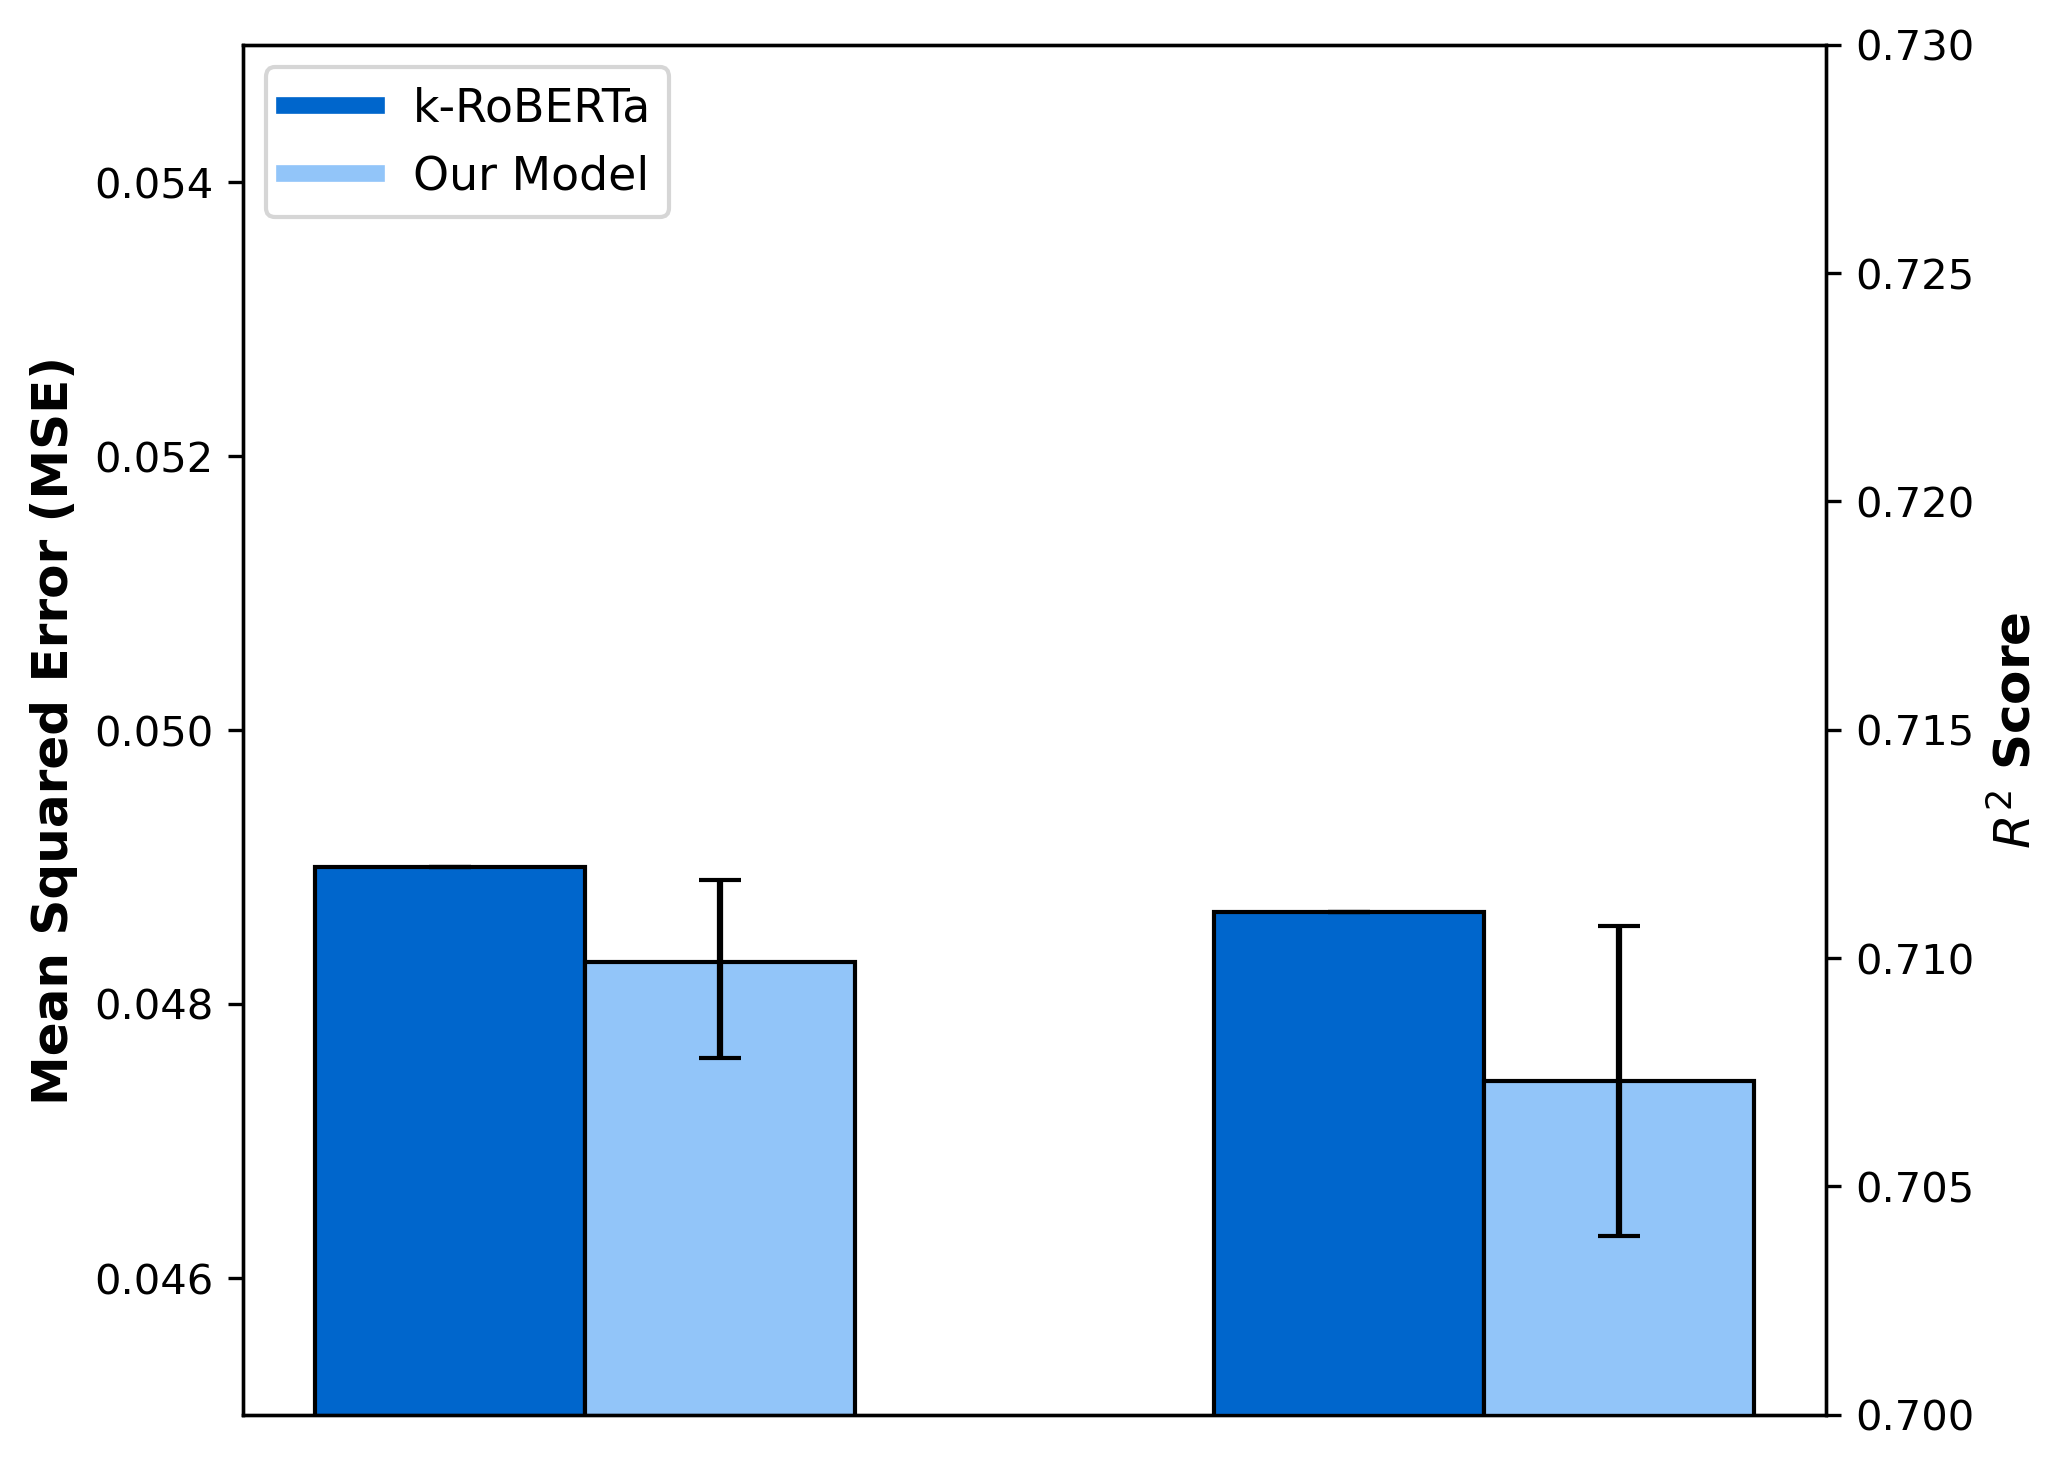

In [100]:
import matplotlib.pyplot as plt
import numpy as np

# Data
metrics = ["MSE", "$R^2$"]
sota_values = [0.0490, 0.7110]  
our_model_values = [0.0483, 0.7073]  

# Create figure and MSE y-axis
fig, ax1 = plt.subplots(figsize=(7, 5), dpi=300)

# Colours: Black for SOTA, White for Our Model
colour1 = "#0066CC"
colour2 = "#92C5F9"
edge_colour = "black"  # Ensures white bars are visible

# MSE y-axis)
bars1 = ax1.bar([-0.15/2, 0.15/2], [sota_values[0], our_model_values[0]], width=0.15, 
                color=[colour1, colour2], edgecolor=edge_colour, yerr=[[0,0.0007],[0, 0.0006]], capsize=5)

ax1.set_ylabel("Mean Squared Error (MSE)", fontsize=12, fontweight="bold")
ax1.set_ylim(0.045, 0.055)

# R^2 y-axis 
ax2 = ax1.twinx()
bars2 = ax2.bar([0.5-0.15/2, 0.5+0.15/2], [sota_values[1], our_model_values[1]], width=0.15, 
                color=[colour1, colour2], edgecolor=edge_colour, yerr=[[0,0.0034],[0, 0.0034]], capsize=5)

ax2.set_ylabel("$R^2$ Score", fontsize=12, fontweight="bold")
ax2.set_ylim(0.70, 0.73)

# Remove x-axis labels
ax1.set_xticks([])

# Add legend manually
legend_elements = [
    plt.Line2D([0], [0], color=colour1, lw=4, label="k-RoBERTa"),
    plt.Line2D([0], [0], color=colour2, markerfacecolor=colour2, 
               markeredgecolor=edge_colour, lw=4, label="Our Model")
]
ax1.legend(handles=legend_elements, fontsize=11, loc="upper left")

plt.tight_layout()
plt.savefig("mse_r2_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

Finally, for completion, we show here the reduction in anisotropy from the RoBERTa case to the embedding model case.

In [22]:
from datasets import concatenate_datasets

og_ds = concatenate_datasets([train_ds, val_ds, test_ds])
full_embeddings = embedding_model.encode(og_ds["sentence"], show_progress_bar=True)

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

In [45]:
from sklearn.metrics.pairwise import cosine_similarity


# Compute pairwise cosine similarities
cos_sim_matrix = cosine_similarity(full_embeddings)

# Compute mean cosine similarity
mean_cosine_similarity = np.mean(cos_sim_matrix)
print(f"Mean Cosine Similarity: {mean_cosine_similarity:.4f}")

Mean Cosine Similarity: 0.5086
Label Mean: 0.1222


We see a much lower Cosine Similarity, 0.5086. This makes sense. We directly trained our embedding model using score_diff. We pushed vectors that were dissimilar apart, and pulled similar vectors in together, naturally mapping out the space more uniformly with respect to sentiment. This makes the dense head's job easier, since the features are more spread out. Also, notably, this captures the bias of the labeling group, since it directly works with samples of their labelings.